In [1]:
import numpy as np
# import statistics
import matplotlib.pyplot as plt
import matplotlib
import scipy.optimize as opt

# import corner

# from jax import random
# import jax.numpy as jnp
# # import dynesty
from scipy.optimize import curve_fit
from scipy.optimize import minimize
import pandas as pd
from scipy.signal import find_peaks
# import numpyro
# import numpyro.distributions as dist
# from numpyro.infer import MCMC, NUTS
# from numpyro import handlers


def L(f,f0,gamma,A=1):
    return A/(1+(f-f0)**2/gamma**2)
    
def norm_L(v,v0,A):
    return A/(1+((v-v0)**2))





def dLdf(f,f0,gamma,A=1):
    return (-2*A*(f - f0))/((1 + (f - f0)**2/gamma**2)**2*gamma**2)

def L_2(f,f0,a,A):
    return (A/np.pi)*(a/(a**2+(f-f0)**2))

def lorentzian(f, A, f0, gamma):
    return (A / np.pi) * (gamma / ((f - f0)**2 + gamma**2))

def dldf(f, A, f0, gamma):
    return (-2*A*gamma*(f - f0))/(np.pi*(gamma**2 + (f - f0)**2)**2)

def d2ldl2(f, A, f0, gamma):
    retunt (A*gamma*(-2/(gamma**2 + (f - f0)**2)**2 + (8*(f - f0)**2)/(gamma**2 + (f - f0)**2)**3))/np.pi


FSR = (266.4621146+266.4620553)/2


# import emcee
# import corner


def d2Ldx2(x,x0,a):
    return -2/a**2 / (1+(x-x0)**2/a**2)**2 + 8 * ((x-x0)/a**2)**2 / (1+(x-x0)**2/a**2)**3

# Say, "the default sans-serif font is COMIC SANS"
matplotlib.rcParams['font.sans-serif'] = "Comic Sans MS"
# Then, "ALWAYS use sans-serif fonts"
matplotlib.rcParams['font.family'] = "sans-serif"
plt.rcParams['font.size'] = 18          # Default font size for text
plt.rcParams['axes.titlesize'] = 22     # Font size for axes titles
plt.rcParams['axes.labelsize'] = 18     # Font size for axes labels
plt.rcParams['xtick.labelsize'] = 14    # Font size for x-axis tick labels
plt.rcParams['ytick.labelsize'] = 14    # Font size for y-axis tick labels
plt.rcParams['legend.fontsize'] = 15    # Font size for legend

def signal_model(theta, freq):
    """Signal model which is the subtraction of two lorentzian distributions

    Args:
        theta (_type_): signal parameters
        freq (_type_): frequencies of data points 

    Returns:
        _type_: _description_
    """
    f01, gamma1, A1, f02, gamma2, A2, offset = theta
    L1 = L(freq,f01,gamma1, A1)
    L2 = L(freq,f02,gamma2, A2)
    return offset+L1-L2

def log_likelihood(theta, frequencies, data, data2=None):
    """Gaussian log likelihood

    Args:
        theta (_type_): model parameters
        frequencies (_type_): frequencies of data points
        data (_type_): measured data
        sigma (_type_): gaussian noise standard deviation

    Returns:
        _type_: log likelihood
    """
    sigma = theta[-1]
    theta = theta[:-1]
    model_y = signal_model(theta, frequencies)

    log_l =  -0.5 * np.sum(((data - model_y) / sigma) ** 2 + np.log(2 * np.pi * sigma ** 2))

    return log_l

def log_prior(theta, prior_bounds):
    """uniform log prior distribution

    Args:
        theta (_type_): _description_
        prior_bounds (_type_): _description_

    Returns:
        _type_: _description_
    """
    for i in range(len(theta)):
        if theta[i] < prior_bounds[i][0] or theta[i] > prior_bounds[i][1]:
            #print(i, prior_bounds[i], theta[i])
            return -np.inf
        
    # set a prior bound so that one frequency is always greater than the other
    # i.e. f01 is always greater that f02
    if theta[0] <= theta[3]:
        return -np.inf
    
    return 0.0

def log_posterior(theta, frequencies, data, prior_bounds, data2=None, output="both"):
    """log of the numerator of Bayes formula

    Args:
        theta (_type_): _description_
        frequencies (_type_): _description_
        data (_type_): _description_
        prior_bounds (_type_): _description_

    Returns:
        _type_: _description_
    """
    lp = log_prior(theta, prior_bounds)
    #print("lp", lp)
    if not np.isfinite(lp):
        return -np.inf

    return lp + log_likelihood(theta, frequencies, data, data2=data2)


def uniform_prior_sample(nsamples, prior_bounds):
    """function to draw samples from a uniform prior distribution given some ranges

    Args:
        nsamples (_type_): _description_
        prior_bounds (_type_): _description_

    Returns:
        _type_: _description_
    """
    output = np.zeros((nsamples, len(prior_bounds)))
    for i in range(len(prior_bounds)):
        output[:,i] = np.random.uniform(prior_bounds[i][0], prior_bounds[i][1], size=nsamples)

    return output

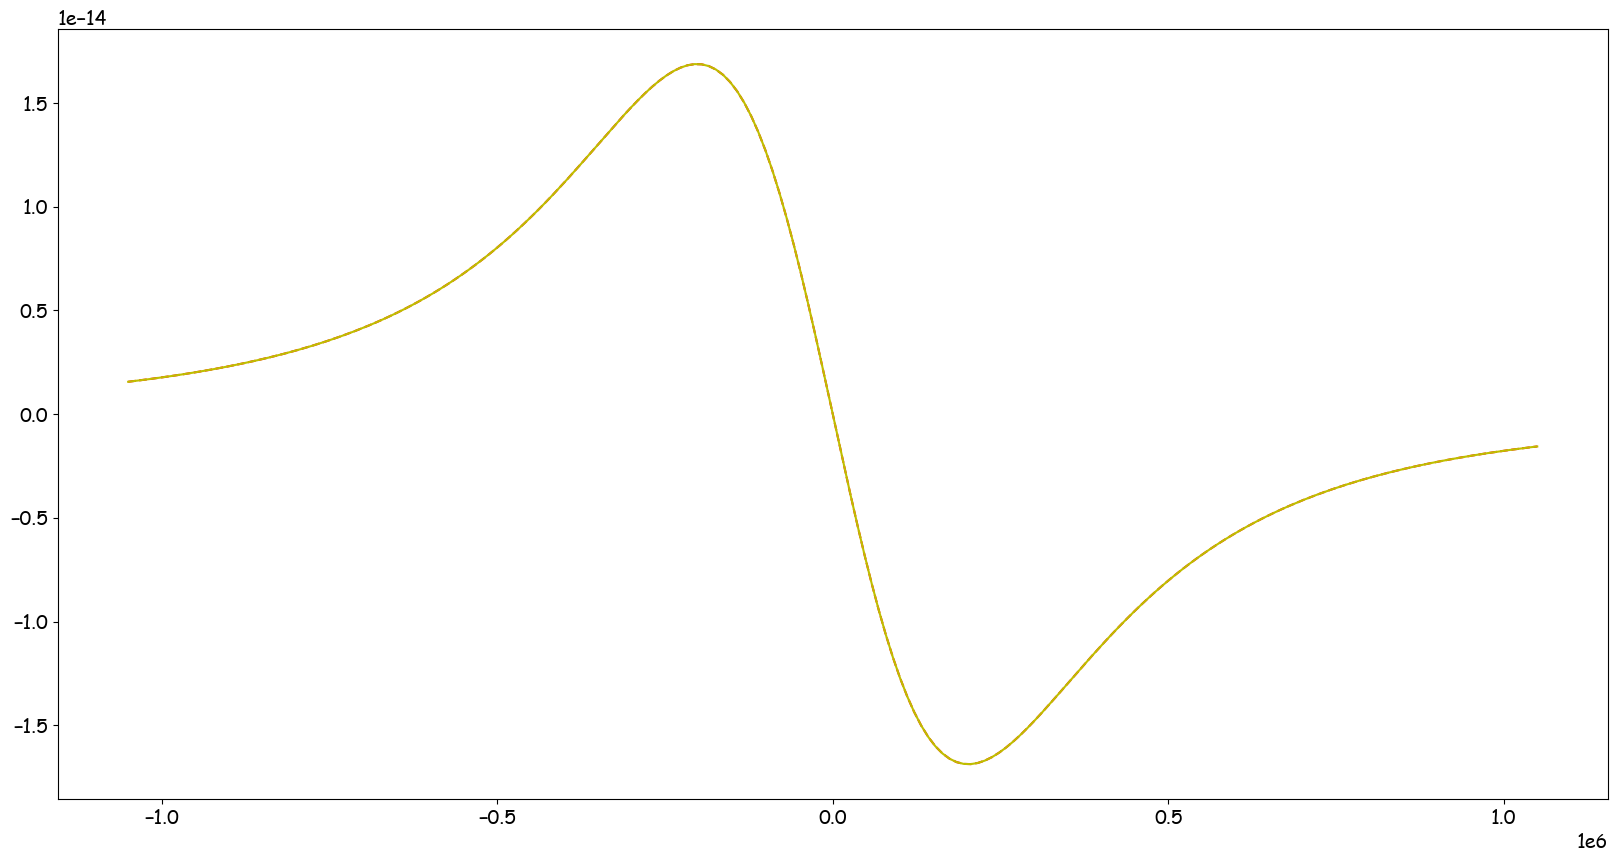

In [2]:
A = 1
gamma = 700e3/2
df = 0.01
dgamma = 1e3
f = np.linspace(-3*gamma,3*gamma,200)
plt.figure(figsize = (20,10))
plt.plot(f,lorentzian(f,A,0,gamma)-lorentzian(f,A,df,gamma), linestyle = "--", color = "r")
plt.plot(f,df*dldf(f,A,0,gamma),linestyle= "-", color = "y")

# def fit_func(x,da1,da2,da3):
#     return d2Ldx2(xx,0,1)*da1+da2*dLdx(xx,0,1)+da3*L(xx,0,1)

In [ ]:
a = 100e3
dx = 0.01
da = 0.0001
xx = np.linspace(-3*a,3*a,200)
plt.plot(xx,L(xx,0,a)-L(xx,0,a+da))
plt.plot(xx,da/a*xx*dLdx(xx,0,a))



In [4]:
import numpy as np

def rotate_points(x, y, theta):
    # Convert theta to radians
    theta_rad = np.radians(theta)
    
    # Rotation matrix
    rotation_matrix = np.array([
        [np.cos(theta_rad), -np.sin(theta_rad)],
        [np.sin(theta_rad), np.cos(theta_rad)]
    ])
    
    # Stack x and y to form a 2 x n matrix
    points = np.vstack((x, y))
    
    # Apply the rotation matrix to each point
    rotated_points = rotation_matrix @ points
    
    # Split the rotated points back into x' and y'
    x_rotated, y_rotated = rotated_points[0, :], rotated_points[1, :]
    
    return x_rotated, y_rotated

# Example usage:
x = np.array([1, 2, 3])
y = np.array([4, 5, 6])
theta = 45  # degrees

x_rotated, y_rotated = rotate_points(x, y, theta)
print("Rotated x coordinates:", x_rotated)
print


Rotated x coordinates: [-2.12132034 -2.12132034 -2.12132034]


<function print(*args, sep=' ', end='\n', file=None, flush=False)>

HWP0 output power: 0.96(P), 0.04(S)
QWP output power: 0.95(P), 0.05(S)
HWP1 output power: 0.28(P), 0.72(S)
HWP2 output power: 0.51(P), 0.49(S)
Homodyne signal: 0.06
relative phase between p and s at QWP output: -85.18 deg


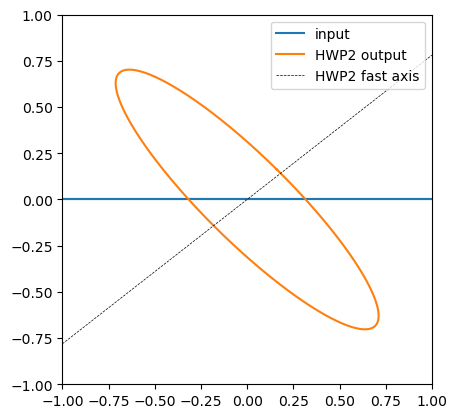

In [58]:
from scipy.optimize import curve_fit

tt = np.linspace(0,2*np.pi,1000)

def phase_shift(tt,yy,theta):
    def mysin(tt,omega,A,theta):
        return A*np.sin(omega*tt+theta)
    yy_params,_ = curve_fit(mysin,tt,yy)
    omega,A,theta0 = yy_params
    return mysin(tt,omega,A,theta+theta0)
    
    # Ensure the result is real (it should be, but due to numerical errors, there might be a tiny imaginary part)
    return np.real(yy2)
    
def WP(ppol,spol,angle,tt=tt,phase=np.pi):
    angle *= np.pi/180
    cc = ppol + 1j*spol 
    # rotate cc
    rotated_cc = cc*np.exp(-1j*angle)
    ppol2,spol2 = np.real(rotated_cc),np.imag(rotated_cc)

    ppol2 = phase_shift(tt,ppol2,phase)
    shifted_cc = ppol2 + 1j*spol2
    reverted_cc = shifted_cc*np.exp(1j*angle)
    ppol3,spol3 = np.real(reverted_cc),np.imag(reverted_cc)
    return ppol3,spol3

def HWP(ppol,spol,angle,tt=tt):
    return WP(ppol,spol,angle,tt=tt,phase=np.pi),WP_plot(angle)

def QWP(ppol,spol,angle,tt=tt):
    return WP(ppol,spol,angle,tt=tt,phase=np.pi/2),WP_plot(angle)
    

def WP_plot(angle):
    # Calculate the start and end points of the line
    angle *= np.pi/180
    length = abs(1/np.cos(angle))
    x_end = length * np.cos(angle)
    y_end = length * np.sin(angle)
    return [-x_end, x_end], [-y_end, y_end]

def arctan_deg(x):
    return np.arctan(x)*180/np.pi

def rel_phase(ppol,spol,tt=tt):
    def mysin(tt,omega,A,theta):
        return A*np.sin(omega*tt+theta)
    ppol_params,_ = curve_fit(mysin,tt,ppol)
    spol_params,_ = curve_fit(mysin,tt,spol)
    return ppol_params[2]-spol_params[2]
    
omega = 1
input = (np.cos(omega*tt),0*np.cos(omega*tt))

fa_HWP0 = 0
fa_QWP = 28.7
fa_HWP1 = 351.1
fa_HWP2 = 178.5

HWP0_reading = 6
QWP_reading = 27.5
HWP1_reading = 320.8
HWP2_reading = 140.5

additional = 2

HWPangle = 2.8
QWPangle = 5

show_HWP0 = False
HWP0_angle = HWP0_reading-fa_HWP0
HWP0_out, HWP0_plot = HWP(*input,HWP0_angle)
HWP0_out_p,HWP0_out_s = max(HWP0_out[0])**2,max(HWP0_out[1])**2

show_QWP = False
QWP_angle = QWP_reading-fa_QWP

QWP_out, QWP_plot = QWP(*HWP0_out,QWP_angle)
QWP_out_p,QWP_out_s = max(QWP_out[0])**2,max(QWP_out[1])**2

show_HWP1 = False
HWP1_angle = (HWP1_reading-fa_HWP1)
HWP1_out, HWP1_plot = HWP(*QWP_out,HWP1_angle)
HWP1_out_p,HWP1_out_s = max(HWP1_out[0])**2,max(HWP1_out[1])**2

show_HWP2 = True
HWP2_angle = -(HWP2_reading-fa_HWP2)
HWP2_out, HWP2_plot = HWP(*HWP1_out,HWP2_angle)
HWP2_out_p,HWP2_out_s = max(HWP2_out[0])**2,max(HWP2_out[1])**2

fig,ax = plt.subplots()
ax.plot(*input,label='input')

# HWP0
if show_HWP0:
    ax.plot(*HWP0_out,label='HWP0 output')
    ax.plot(*HWP0_plot,'--k',linewidth=0.5,label='HWP0 fast axis')

# QWP
if show_QWP:
    ax.plot(*QWP_out,label='QWP output')
    ax.plot(*QWP_plot,'--r',linewidth=0.5,label='QWP fast axis')

# HWP1
if show_HWP1:
    ax.plot(*HWP1_out,label='HWP1 output')
    ax.plot(*HWP1_plot,'--k',linewidth=0.5,label='HWP1 fast axis')

# HWP1
if show_HWP2:
    ax.plot(*HWP2_out,label='HWP2 output')
    ax.plot(*HWP2_plot,'--k',linewidth=0.5,label='HWP2 fast axis')


ax.set_aspect('equal', adjustable='box')
ax.set_xlim(-1,1)
ax.set_ylim(-1,1)
ax.legend()

print('HWP0 output power: %.2f(P), %.2f(S)'%(HWP0_out_p,HWP0_out_s))
print('QWP output power: %.2f(P), %.2f(S)'%(QWP_out_p,QWP_out_s))
print('HWP1 output power: %.2f(P), %.2f(S)'%(HWP1_out_p,HWP1_out_s))
print('HWP2 output power: %.2f(P), %.2f(S)'%(HWP2_out_p,HWP2_out_s))

print('Homodyne signal: %.2f'%((HWP2_out_p-HWP2_out_s)*5))
print('relative phase between p and s at QWP output: %.2f deg'%(rel_phase(*QWP_out)*180/np.pi))

# Finesse noise plots

# Transfer Function 

In [13]:
%cd "/Users/cosmos1998/Library/CloudStorage/GoogleDrive-thejaschilkunda.seetharamu@ligo.org/Shared drives/A+ OMC/CIT_OMC_build/data/Cavity1/pol_BHD/Pol_2/Homo_ang_90/040724/FSR_noise"
fsr_noise_dbm = -75.27
finesse_noise_dbm =  -75.43 

fsr = pd.read_csv("")

/Users/cosmos1998/Library/CloudStorage/GoogleDrive-thejaschilkunda.seetharamu@ligo.org/Shared drives/A+ OMC/CIT_OMC_build/data/Cavity1/pol_BHD/Pol_2/Homo_ang_90/040724/FSR_noise


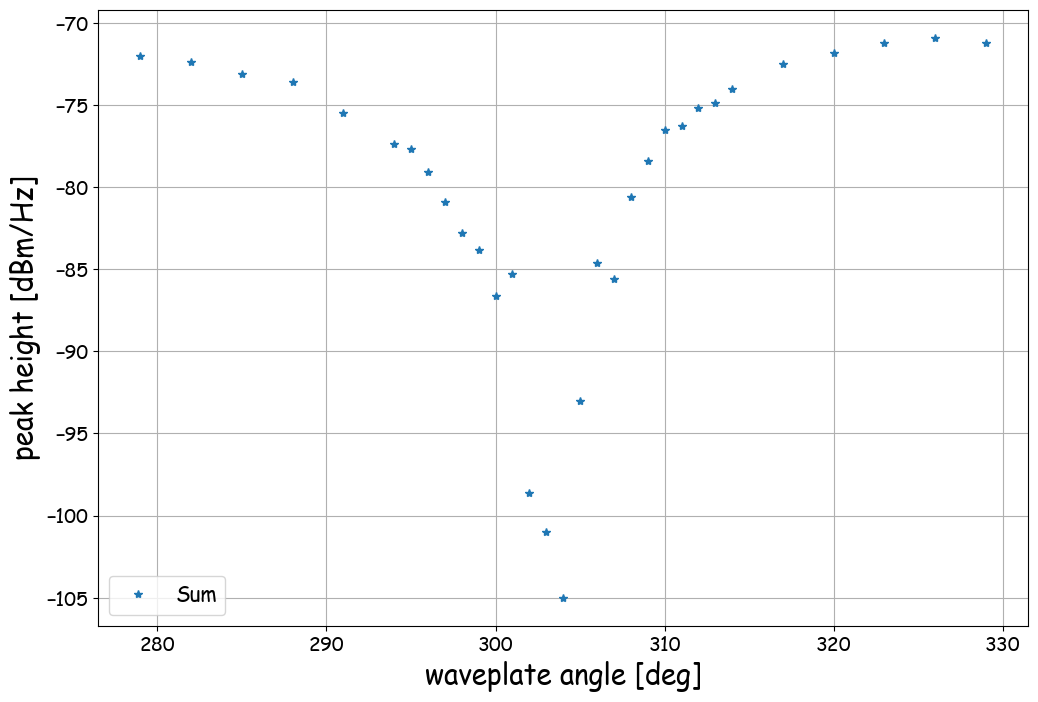

In [89]:
angle = np.array([279,282,285,288,291,294,295,296,297,298,299,300,301,302,303,304,305,306,307,308,309,310,311,312,313,314,317,320,323,326,329])
peak_height = np.array([-72,-72.4,-73.1,-73.6,-75.5,-77.4,-77.7,-79.1,-80.9,-82.8,-83.8,-86.6,-85.3,-98.6,-101,-105,-93,-84.6,-85.6,-80.6,-78.4,-76.5,-76.3,-75.2,-74.9,-74,-72.5,-71.8,-71.2,-70.9,-71.2])

fig,ax = plt.subplots(figsize=(12,8))
ax.plot((angle),peak_height,'*', label="Sum")
ax.set_xlabel('waveplate angle [deg]', fontsize = 20)
ax.set_ylabel('peak height [dBm/Hz]', fontsize = 20)
ax.grid()
# ax.axhline(fsr_noise_dbm, color = "r", label="FSR")
# ax.axhline(finesse_noise_dbm, color = "g", label = "Finesse")
ax.legend()
#ax.set_xlim(-80,40)

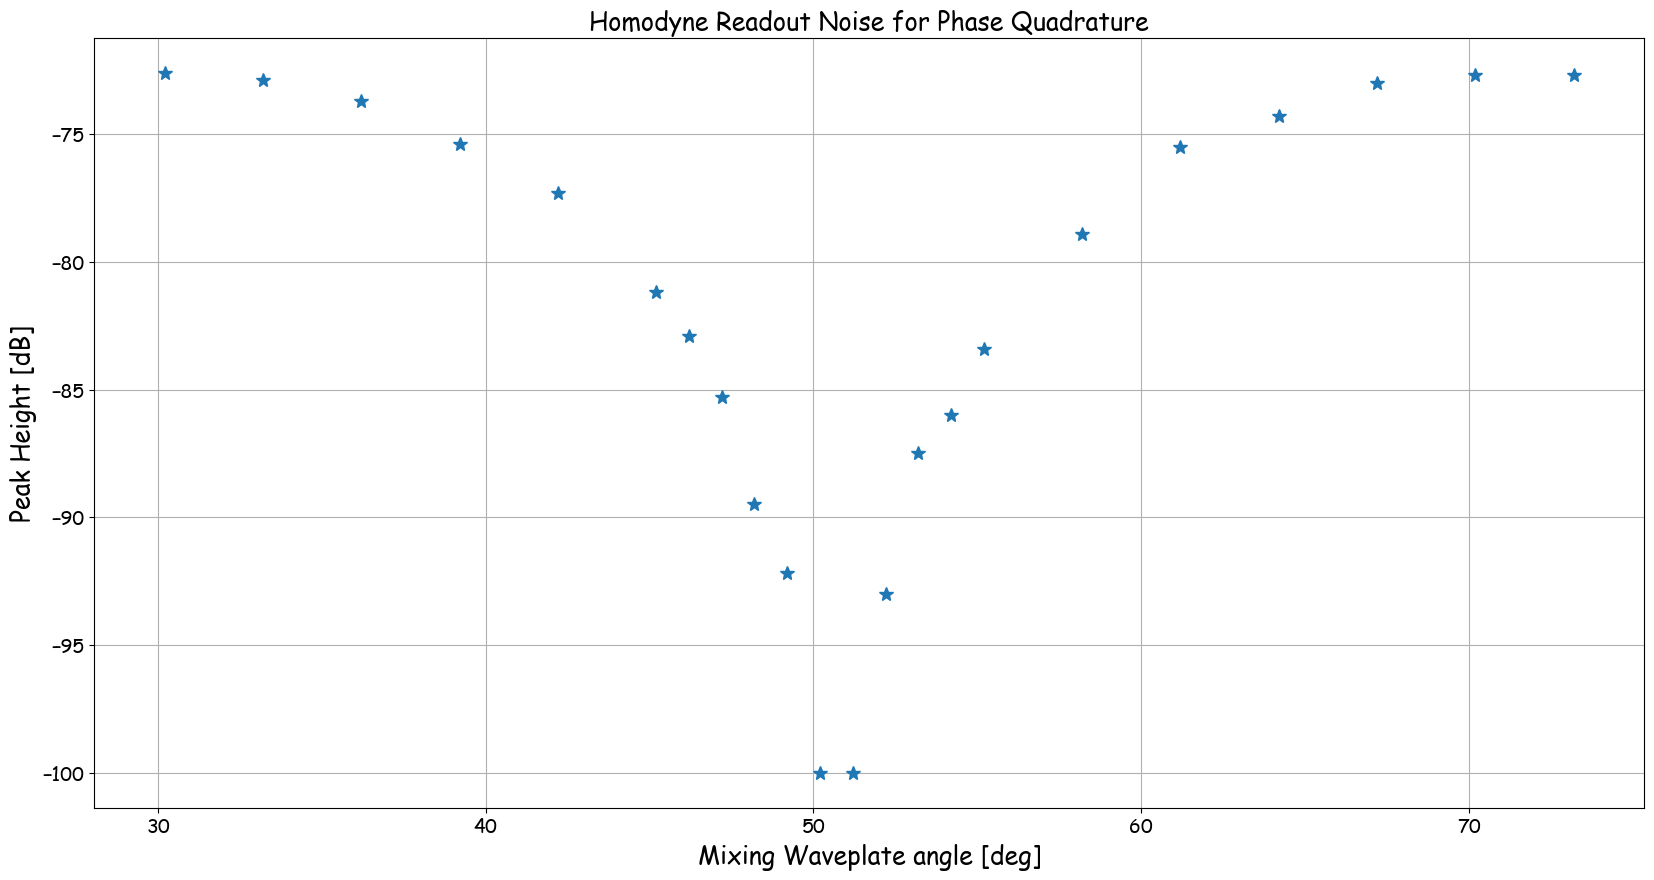

In [113]:
angle = np.array([300.2,303.2,306.2,309.2,312.2,315.2,316.2,317.2,318.2,319.2,320.2,321.2,322.2,323.2,324.2,325.2,328.2,331.2,334.2,337.2,340.2,343.2])
peak_height = np.array([-72.6,-72.9,-73.7,-75.4,-77.3,-81.2,-82.9,-85.3,-89.5,-92.2,-100,-100,-93,-87.5,-86,-83.4,-78.9,-75.5,-74.3,-73,-72.7,-72.7])
error = np.array([3,2,1,1])
fig,ax = plt.subplots(figsize=(20,10))
ax.plot(((angle+90)%360),peak_height,'*', markersize = 10)
# ax.plot((angle)%360+90,peak_height,'*')
ax.set_xlabel('Mixing Waveplate angle [deg]', fontsize = 18)
ax.set_ylabel('Peak Height [dB]', fontsize = 18)
ax.set_title("Homodyne Readout Noise for Phase Quadrature", fontsize = 18)
ax.grid()
#ax.set_xlim(-80,40)


[ 91.04655645  70.80603803  65.39007067  53.19548053  43.06381865
  30.85728864  24.04271014  17.55560729 104.38296065 165.47459573
 145.27723707]
[192.26677329 219.90373926 242.2410067  268.95344355 289.97148971
 302.35475048 334.70362541]


<>:27: SyntaxWarning: invalid escape sequence '\T'
<>:28: SyntaxWarning: invalid escape sequence '\z'
<>:27: SyntaxWarning: invalid escape sequence '\T'
<>:28: SyntaxWarning: invalid escape sequence '\z'
/var/folders/gh/jhjc71wd5zb_26ghvct14n940000gp/T/ipykernel_23295/1089773224.py:27: SyntaxWarning: invalid escape sequence '\T'
  ax.set_ylabel("Optimum Polarisation Angle $\Theta_{opt}$ [deg]")
/var/folders/gh/jhjc71wd5zb_26ghvct14n940000gp/T/ipykernel_23295/1089773224.py:28: SyntaxWarning: invalid escape sequence '\z'
  ax.set_xlabel("Homodyne angle $\zeta$ [deg]")


Text(0.5, 0, 'Homodyne angle $\\zeta$ [deg]')

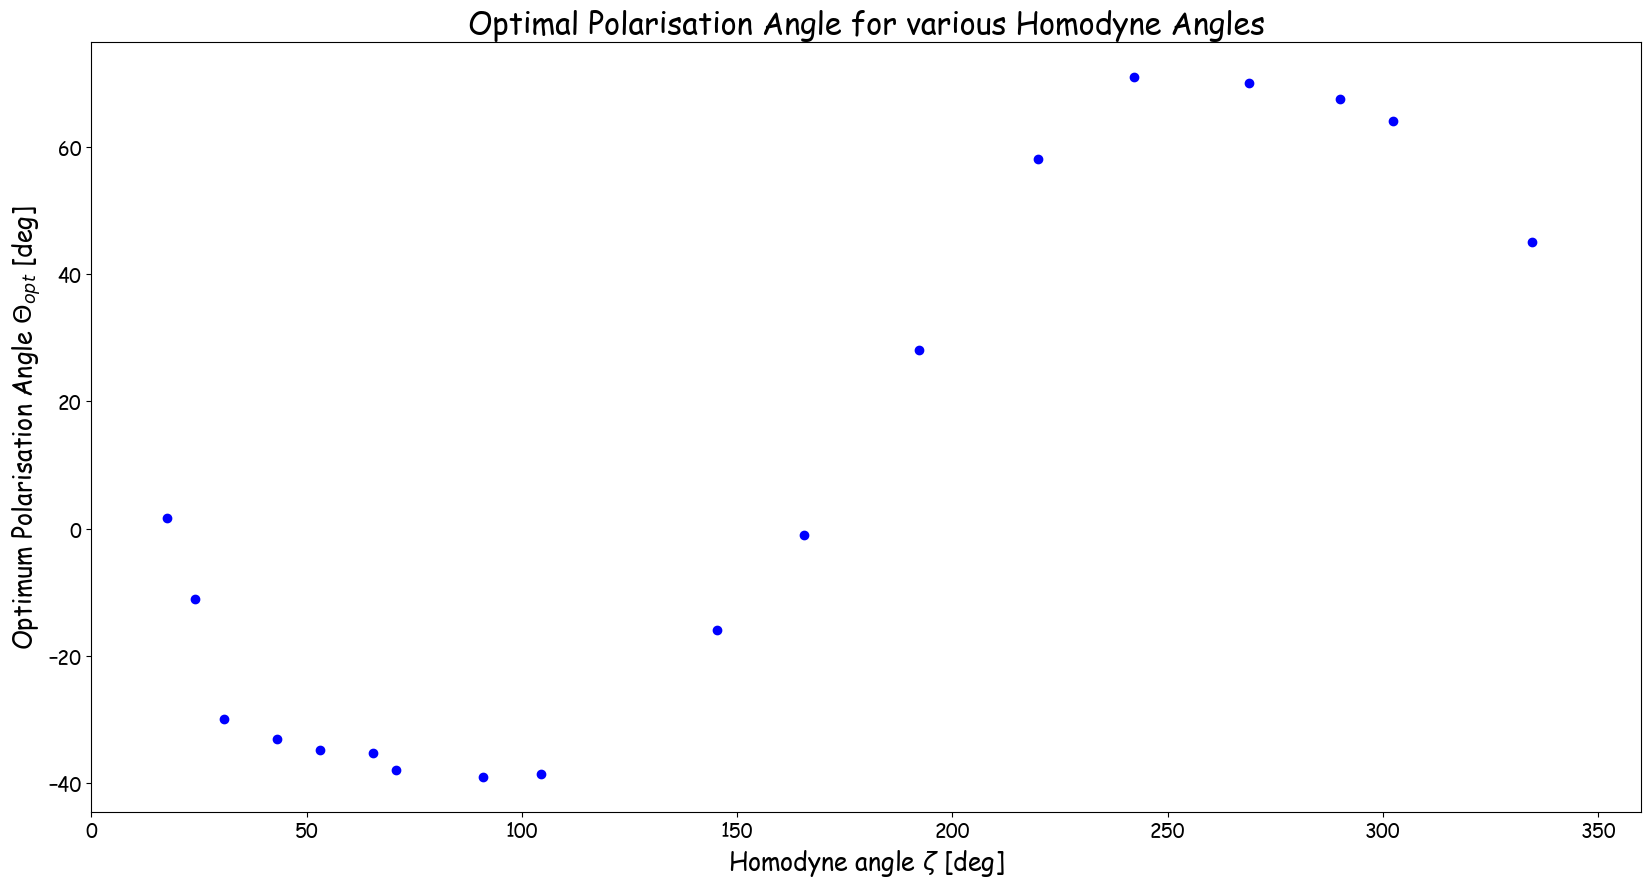

In [13]:
ref = np.array([0,1.9,2.38,3.38, 4.1, 4.8, 5.1, 5.32,
                -1.26, -5.2, -4.4])
ref2 = np.array([-2.1*5/2, -4.10,-2.45,0,1.97,3.03,5.05])

# The above arrays must be homodyne signal readings

max_ref = 2.23*5/2 # Thw raw data in email has diufferent numbers
min_ref = -2.15*5/2  

ofs_ref = (max_ref + min_ref)/2
amp_ref = (max_ref - min_ref)/2
#max_ref = np.sqrt(1.8*0.18)*2*5
eta = np.arccos((ref-ofs_ref)/amp_ref)
eta2 = np.arccos(-(ref2-ofs_ref)/amp_ref)+np.pi
print(eta*180/np.pi)
print(eta2*180/np.pi)
opt = np.array([321,322,324.8,325.2,327,330,349,360+1.7,
       321.5,359,344])-360
opt2 = [28, 58 ,71, 70, 67.5, 64, 45]

fig,ax = plt.subplots(figsize=(20,10))
ax.scatter(eta*180/np.pi,opt, color="b")
ax.scatter(eta2*180/np.pi,opt2, color="b")
ax.set_xlim(0,360)

ax.set_title("Optimal Polarisation Angle for various Homodyne Angles")
ax.set_ylabel("Optimum Polarisation Angle $\Theta_{opt}$ [deg]")
ax.set_xlabel("Homodyne angle $\zeta$ [deg]")
    
#ax.set_xlabel('homodyne angle [deg]')

5.032834710150645

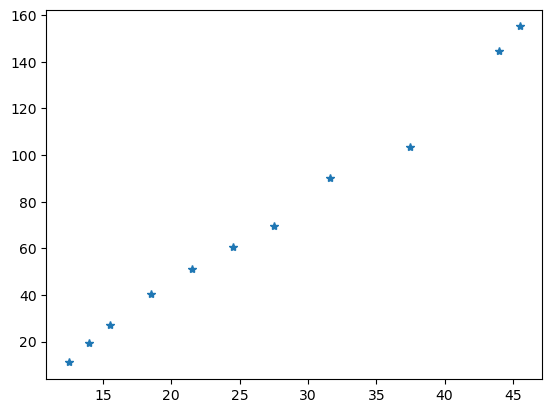

In [169]:
from scipy.interpolate import interp1d
QPD = [31.6,37.5, 45.5, 44.0,27.5, 24.5, 21.5, 18.5, 15.5, 14,12.5]
ref = np.array([0, -1.26, -4.9, -4.4,1.90, 2.64, 3.38, 4.1, 4.8, 5.1, 5.3])


eta = np.arccos(ref/max_ref)
QPD_eta = interp1d(np.rad2deg(eta),QPD)
plt.plot(QPD,np.rad2deg(eta),'*')
QPD_eta(90-40) - QPD_eta(90-60)

# Birefringence Data

,Time,Error signal,Difference Signal,pBeam,sBeam,Difference
0,-0.000468,-0.021387,-0.016040,0.032080,0.042774,-0.010693
1,-0.000467,-0.024060,-0.016040,0.037427,0.045447,-0.008020
2,-0.000466,-0.021387,-0.016307,0.032080,0.040100,-0.008020
3,-0.000465,-0.021387,-0.016307,0.032080,0.042774,-0.010693
4,-0.000463,-0.018713,-0.016040,0.034754,0.045447,-0.010693
...,...,...,...,...,...,...
1019,0.000735,0.018713,-0.016307,0.024060,0.034754,-0.010693
1020,0.000736,0.018713,-0.016842,0.026734,0.040100,-0.013367
1021,0.000738,0.024060,-0.016575,0.026734,0.034754,-0.008020
1022,0.000739,0.021387,-0.017109,0.021387,0.034754,-0.013367


0.03181287
0.029406799999999955


,% Time (s),Channel A (Output 2) (V),Channel B (Input 2) (V),Channel C (Input 3) (V),Channel D (Input 4) (V)
0,-0.124009,0.181788,-0.026734,0.000000,0.013367
1,-0.123813,0.178279,0.000000,0.000000,0.010693
2,-0.123617,0.174937,0.026734,0.000000,0.010693
3,-0.123421,0.171512,-0.053467,0.000000,0.010693
4,-0.123225,0.168170,0.000000,0.000000,0.016040
...,...,...,...,...,...
1019,0.075800,4.927569,0.000000,0.026734,0.013367
1020,0.075997,4.925313,-0.026734,0.000000,0.010693
1021,0.076193,4.923141,-0.026734,-0.026734,0.013367
1022,0.076389,4.920802,-0.026734,-0.026734,0.013367


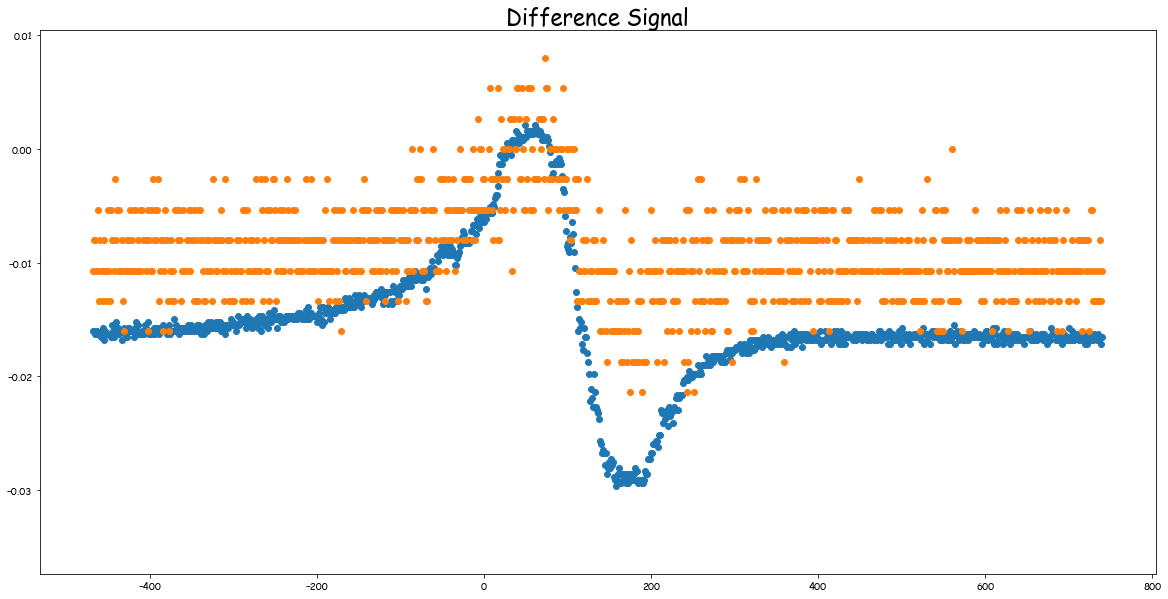

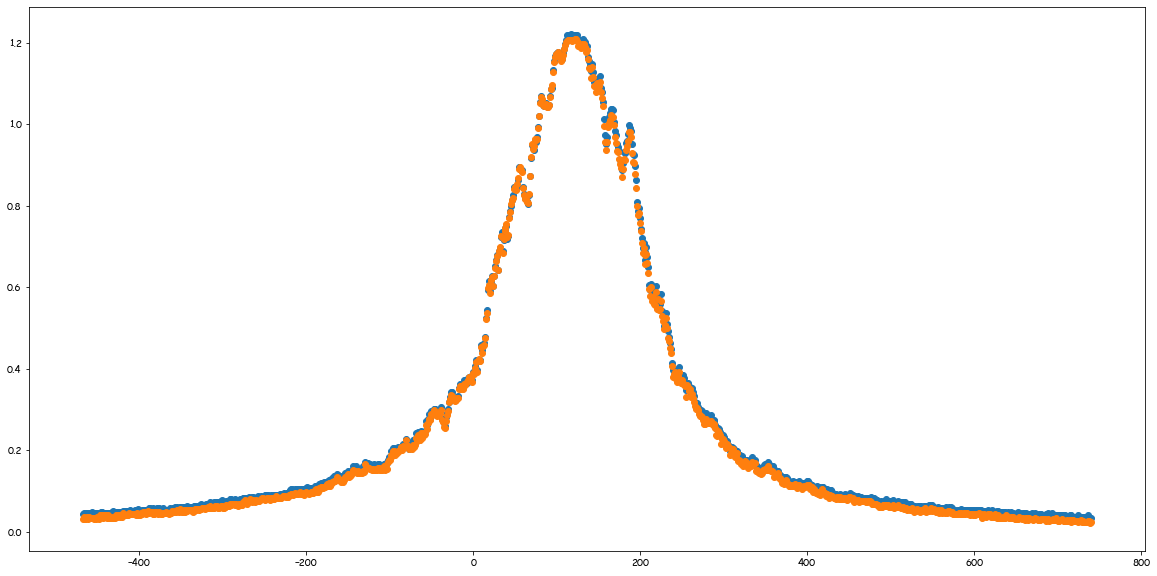

In [8]:
bir = pd.read_csv("/Users/cosmos1998/Library/CloudStorage/GoogleDrive-thejaschilkunda.seetharamu@ligo.org/Shared drives/A+ OMC/CIT_OMC_build/data/Cavity1/pol_BHD/Pol_2/biref_cavityscan_20240705_115901_Traces.csv", skiprows = range(0,16))            
bir =bir.set_axis(['Time', 'Error signal',"Difference Signal", 'pBeam', 'sBeam' ], axis=1)
bir["Difference"] = bir["pBeam"]-bir["sBeam"]
display(bir)
fig, ax = plt.subplots(figsize= (20,10))
ax.scatter(np.array(bir["Time"].tolist())/1e-6,bir["Difference Signal"].tolist())
ax.set_title("Difference Signal", fontsize = 22)
ax.scatter(np.array(bir["Time"].tolist())/1e-6,(bir["Difference"]).tolist())

# Plot the 


fig, ax = plt.subplots(figsize= (20,10))
ax.scatter(np.array(bir["Time"].tolist())/1e-6,(bir["sBeam"]).tolist())
ax.scatter(np.array(bir["Time"].tolist())/1e-6,(bir["pBeam"]).tolist())
print (np.max(np.array(bir["Difference Signal"]))-np.min(np.array(bir["Difference Signal"])))
print (np.max(np.array(bir["Difference"]))-np.min(np.array(bir["Difference"])))

las_scan = pd.read_csv("/Users/cosmos1998/Library/CloudStorage/GoogleDrive-thejaschilkunda.seetharamu@ligo.org/Shared drives/A+ OMC/CIT_OMC_build/data/Cavity1/pol_BHD/Pol_2/laserscan_20240705_115440_Traces.csv", skiprows = range(0,16))
df = df.drop('Channel B (Input 2) (V)', axis=1)
las_scan =las_scan.set_axis(['Time', 'laser voltage',"Difference Signal", 'pBeam', 'sBeam' ], axis=1)



## Converting from time base to frequency base using laser scan data

I want these curves in frequency base. Right now they're in time base. 
The laser scan data has laser scan voltage with the resonance peaks, and I want to use this the knowledge of the FSR of the FSR of the cavity to estimate the finesse and the resonance frequency position. 

I can then use the difference signal to compare this with 

(0.0058, 0.009551)

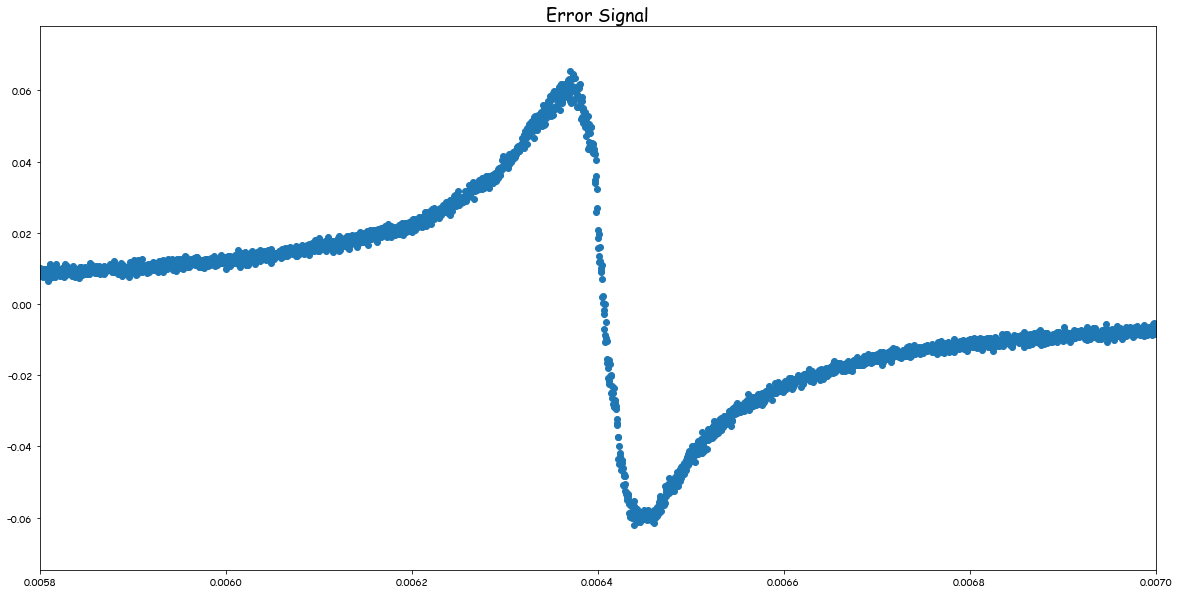

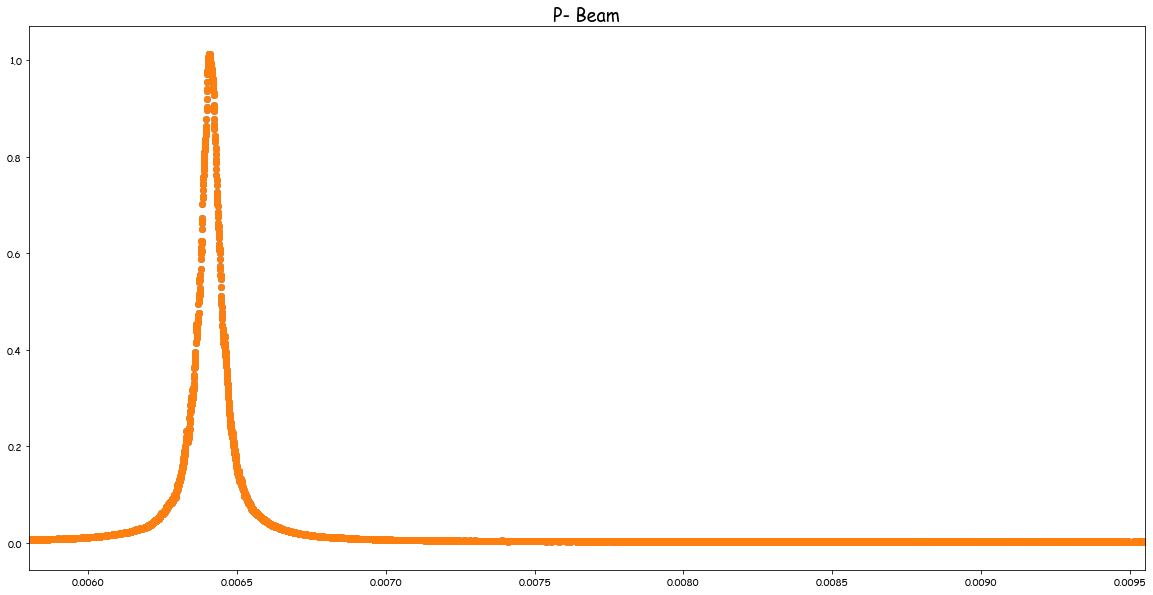

In [122]:
bir2 = pd.read_csv("/Users/cosmos1998/Library/CloudStorage/GoogleDrive-thejaschilkunda.seetharamu@ligo.org/Shared drives/A+ OMC/CIT_OMC_build/data/Cavity1/pol_BHD/Pol_2/MokuDataLoggerData_20240705_120029.csv", skiprows = range(0,12))
bir2 =bir2.set_axis(['Time','Error signal',"Difference Signal", 'pBeam', 'sBeam' ], axis=1)
bir2 = bir2[(bir2['Time']<0.009551) & (bir2["Time"]>0.0058)]

fig, ax = plt.subplots(figsize = (20,10))
ax.set_title("Error Signal", fontsize = 18)
ax.scatter(bir2["Time"].tolist(),bir2["Error signal"].tolist())
ax.set_xlim((0.0058,0.007))
fig, ax = plt.subplots(figsize = (20,10))
ax.set_title("P- Beam", fontsize = 18)
ax.scatter(bir2["Time"].tolist(),bir2["pBeam"].tolist())
ax.scatter(bir2["Time"].tolist(),bir2["pBeam"].tolist())
ax.set_xlim((0.0058,0.009551))

# Laser scan Data

We want to derive PZT response value (FSR/V) from the scan data here. 


In [140]:
las_scan = pd.read_csv("/Users/cosmos1998/Library/CloudStorage/GoogleDrive-thejaschilkunda.seetharamu@ligo.org/Shared drives/A+ OMC/CIT_OMC_build/data/Cavity1/pol_BHD/Pol_2/MokuDataLoggerData_20240705_120537.csv", skiprows = range(0,12))
# las_scan = las_scan.drop('Channel B (Input 2) (V)', axis=1)
las_scan =las_scan.set_axis(['Time', 'err_sig','Signal', 'pBeam', 'scan' ], axis=1)
print (np.max(las_scan["Time"]))

4.9999996


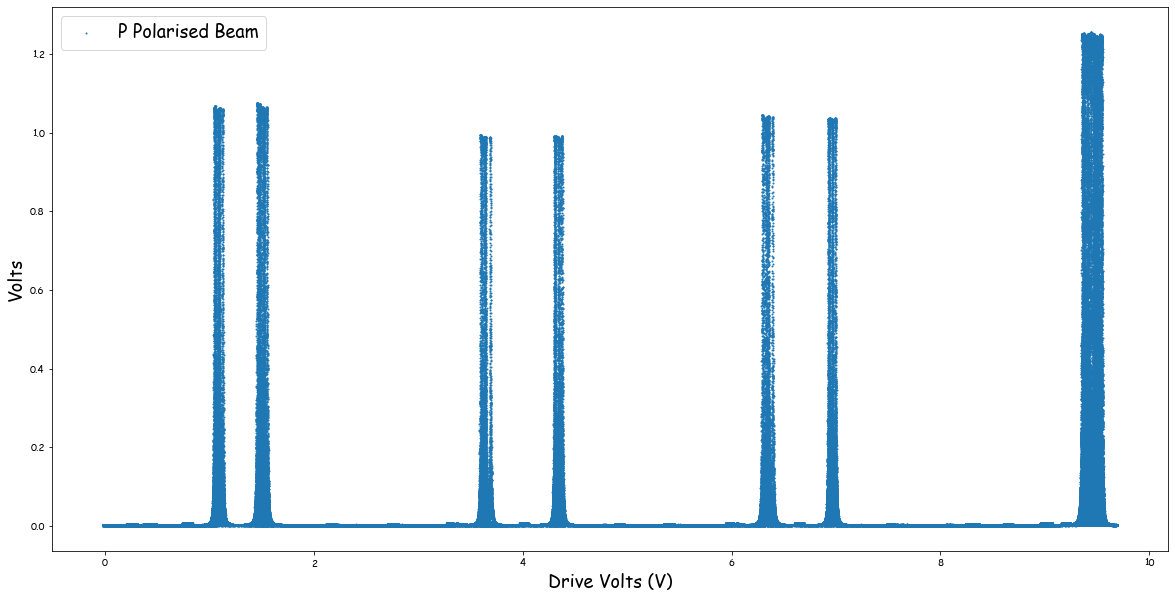

In [139]:
las_scan = las_scan[(las_scan["Time"]>0.1) & (las_scan['Time']<3)]
#it was between 520 ms and 560 ms 
# fig, ax = plt.subplots(figsize = (20,10))
# ax.set_title("A+ OMC Cavity 1: FSR = 266.462 MHz", fontsize = 18)
# ax.scatter(las_scan["Time"].tolist(),np.array(las_scan["scan"])/10, label = "laser scan (x 10 V)", s = 1) #Divide this by 10 for visual aid, then convert it back
# #ax.scatter(las_scan["Time"].tolist(),las_scan["Signal"].tolist(), label = "signal")
# ax.scatter(las_scan["Time"].tolist(),las_scan["pBeam"].tolist(), label = "P Polarised Beam", s = 1)
# ax.set_xlabel("Time (s)", fontsize = 18)
# ax.set_ylabel("Volts", fontsize = 18)
# peaks, heights = find_peaks(las_scan["pBeam"].tolist(), height = 0.99)
# ax.legend(fontsize= 18)

fig, ax = plt.subplots(figsize = (20,10))
ax.scatter(las_scan["scan"].tolist(),las_scan["pBeam"].tolist(), label = "P Polarised Beam", s = 1)
ax.set_xlabel("Drive Volts (V)", fontsize = 18)
ax.set_ylabel("Volts", fontsize = 18)
peaks, heights = find_peaks(las_scan["pBeam"].tolist(), height = 0.99)
ax.legend(fontsize= 18)


# print (peaks)
# for i in peaks: 
#     print (las_scan.iloc[i])
# # ax.set_xlim((40.8e-3,42e-3))
# display(las_scan)

# ax.text(0.523079, 1, "Peak at {} sec corresponds \n to {} PZT drive V".format(las_scan.iloc[7696]["Time"],las_scan.iloc[7696]["scan"]))
# ax.text(0.5455, 1, "Peak at {} sec corresponds \n to {} PZT drive V".format(las_scan.iloc[81535]["Time"],las_scan.iloc[81535]["scan"]))

# Trimming the scanc and defining the position of peaks and mode-spacings

833697
11671770


,Time,err_sig,signal,pBeam,scan,fitted_scan
0,0.110775,0.000150,-0.017024,0.002053,-0.019890,-0.008689
1,0.110776,0.001262,-0.017216,0.002652,-0.016789,-0.008689
2,0.110776,0.001486,-0.017088,0.002534,-0.014543,-0.008690
3,0.110776,0.001807,-0.016607,0.001957,-0.013688,-0.008691
4,0.110777,0.003304,-0.016265,0.001850,-0.013474,-0.008691
...,...,...,...,...,...,...
11671753,4.779476,0.000278,-0.016885,0.001529,-0.008555,-0.008773
11671754,4.779477,0.000471,-0.016863,0.001754,-0.008662,-0.008773
11671755,4.779477,0.001016,-0.016457,0.002117,-0.012190,-0.008772
11671756,4.779478,0.000588,-0.016361,0.002042,-0.010693,-0.008771


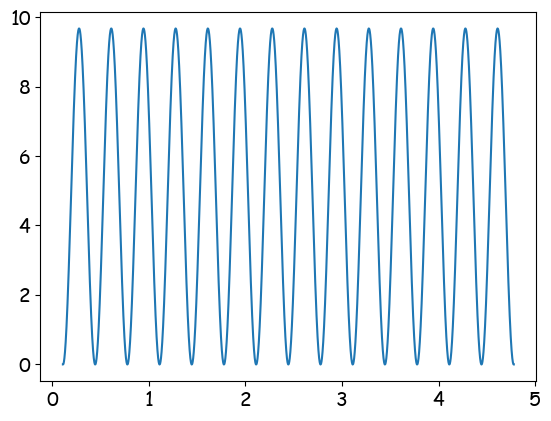

In [5]:
#Find the first and last minimum occurences of the voltage scan adn trim hte data. 
f_scan = 3
import pandas as pd
# The following code trims the las_scan to first minimum of the sinusoid to the last minimum. 
las_scan = pd.read_csv("/Users/cosmos1998/Library/CloudStorage/GoogleDrive-thejaschilkunda.seetharamu@ligo.org/Shared drives/A+ OMC/CIT_OMC_build/data/Cavity1/pol_BHD/Pol_2/MokuDataLoggerData_20240705_120537.csv", skiprows = range(0,12))
las_scan =las_scan.set_axis(['Time', 'err_sig','signal', 'pBeam', 'scan' ], axis=1)
las_scan = las_scan[(las_scan['Time']<1/f_scan)]
# Find the first minimum value
min_value = las_scan["scan"].min()
# Find the position of the first minimum value
min_1 = (las_scan["scan"] == min_value).idxmax()

las_scan = pd.read_csv("/Users/cosmos1998/Library/CloudStorage/GoogleDrive-thejaschilkunda.seetharamu@ligo.org/Shared drives/A+ OMC/CIT_OMC_build/data/Cavity1/pol_BHD/Pol_2/MokuDataLoggerData_20240705_120537.csv", skiprows = range(0,12))
las_scan =las_scan.set_axis(['Time', 'err_sig','signal', 'pBeam', 'scan' ], axis=1)
las_scan = las_scan[(las_scan['Time']>(np.max(las_scan["Time"]))-(1/f_scan)) & (las_scan['Time']<np.max(las_scan["Time"]))]
min_value = las_scan["scan"].min()
# Find the position of the first minimum value
min_2 = (las_scan["scan"] == min_value).idxmax()

las_scan = pd.read_csv("/Users/cosmos1998/Library/CloudStorage/GoogleDrive-thejaschilkunda.seetharamu@ligo.org/Shared drives/A+ OMC/CIT_OMC_build/data/Cavity1/pol_BHD/Pol_2/MokuDataLoggerData_20240705_120537.csv", skiprows = range(0,12))
las_scan =las_scan.set_axis(['Time', 'err_sig','signal', 'pBeam', 'scan' ], axis=1)

las_scan = las_scan.loc[min_1:min_2]

def fit_sin(tt, yy):
    # GUESS
    ff = np.fft.fftfreq(len(tt), (tt[1]-tt[0]))   # assume uniform spacing
    Fyy = abs(np.fft.fft(yy))
    guess_freq = abs(ff[np.argmax(Fyy[1:])+1])   # excluding the zero frequency "peak", which is related to offset
    guess_amp = np.std(yy) * 2.**0.5
    guess_offset = np.mean(yy)
    guess = np.array([guess_amp, 2.*np.pi*guess_freq, 0., guess_offset])

    guess = np.array([5.0, 2.*np.pi*3., -3.7, 5.])

    sinfunc = lambda t, A, w, p, c: A * np.sin(w*t + p) + c
    popt, pcov = curve_fit(sinfunc, tt, yy, p0=guess)
    A, w, p, c = popt
    f = w/(2.*np.pi)
    fitfunc = lambda t: A * np.sin(w*t + p) + c
    return {"amp": A, "omega": w, "phase": p, "offset": c, "freq": f, 
            "period": 1./f, "fitfunc": fitfunc, "maxcov": np.max(pcov), 
            "rawres": (guess,popt,pcov)}

t = np.array(las_scan["Time"].tolist())
v = las_scan["scan"].tolist()
fitted = fit_sin(t, v)

las_scan["fitted_scan"] = fitted["fitfunc"](t)

# plt.plot(las_scan["Time"], las_scan["scan"]) # from this I know there are 14 cycles
points_per_scan = len(las_scan["scan"]) // 14
print(points_per_scan)
print(len(las_scan["Time"]))

# trim the data points to make the dataframe divisible by 14 
extra_points_to_trim = (points_per_scan*14)-len(las_scan["scan"])
las_scan_trimmed = las_scan.iloc[:extra_points_to_trim]

las_scan_trimmed = las_scan_trimmed.reset_index(drop=True)
# Split the voltage and tiem data into 14 cycles
t = las_scan_trimmed["Time"].to_numpy()
v = las_scan_trimmed["fitted_scan"].to_numpy()
plt.plot(t,v)
pBeam = las_scan_trimmed["pBeam"].to_numpy()
t_arrays = np.array_split(t, 14)
v_arrays = np.array_split(v,14)
p_arrays = np.array_split(pBeam,14)
display(las_scan_trimmed)
# 3 hz scan rate
mode_spacings_up = []
mode_spacings_down = []
volts_up = []
volts_down = []
time_up=[]
time_down=[]
for res in p_arrays:
    # Detect peaks
    up_scan = v[:len(res)//2]
    t_up = t[:len(res)//2]
    t_down=  t[len(res)//2:]
    down_scan = v[len(res)//2:]
    peaks_up, _ = find_peaks(res[:len(res)//2], height=0.90, prominence = 0.9)  # Adjust 'height' as needed based on your data
    peaks_down,_ = find_peaks(res[len(res)//2:], height=0.90, prominence = 0.9) 
    # Calculate the voltage differences between adjacent peaks
    volts_up.append(up_scan[peaks_up])# voltages of peaks for ramp up of a single scan 
    volts_down.append(down_scan[peaks_down])
    time_up.append(t_up[peaks_up])
    time_down.append(t_down[peaks_down])
    spacing_up = np.diff(up_scan[peaks_up])  # Differences between successive peaks
    spacing_down = np.diff(down_scan[peaks_down])  # Differences between successive peaks
    mode_spacings_up.append(spacing_up)
    mode_spacings_down.append(spacing_down)

    
mode_spacings_down = [np.abs(i) for i in mode_spacings_down]    
fsr_1_up=np.mean([i[0] for i in mode_spacings_up])
err_1_up = np.std([i[0] for i in mode_spacings_up],ddof = 1)
fsr_2_up=np.mean([i[1] for i in mode_spacings_up])
err_2_up = np.std([i[1] for i in mode_spacings_up],ddof = 1)
fsr_3_up=np.mean([i[2] for i in mode_spacings_up])
err_3_up = np.std([i[2] for i in mode_spacings_up],ddof = 1)
fsr_1_down= np.mean([i[0] for i in mode_spacings_down])
err_1_down = np.std([i[0] for i in mode_spacings_down],ddof = 1)
fsr_2_down=np.mean([i[1] for i in mode_spacings_down])
err_2_down = np.std([i[1] for i in mode_spacings_down],ddof = 1)
fsr_3_down= np.mean([i[2] for i in mode_spacings_down])
err_3_down = np.std([i[2] for i in mode_spacings_down],ddof = 1)
fsr_vals = [fsr_1_up,fsr_2_up,fsr_3_up,fsr_1_down,fsr_2_down,fsr_3_down]


In [ ]:
fig, ax = plt.subplots(3,1,figsize = (20,30))
ax[0].scatter(np.array(las_scan["Time"].tolist())[0:833697//2],np.array(las_scan["pBeam"].tolist())[0:833697//2] )
ax[0].scatter(np.array(las_scan["Time"].tolist())[0:833697//2],(np.array(las_scan["scan"].tolist())/10)[0:833697//2] )
ax[0].set_xlabel("Time (s)")
ax[0].set_ylabel("Volts (V)")
ax[0].set_title("Scan")
ax[1].scatter(np.array(las_scan["scan"].tolist())[0:833697//2],np.array(las_scan["pBeam"].tolist())[0:833697//2] )
ax[1].set_xlabel("PZT drive (V)")
ax[1].set_ylabel("Volts (V)")
ax[1].set_title("Ramp up scan")
ax[2].scatter(np.array(las_scan["scan"].tolist())[0:833697],np.array(las_scan["pBeam"].tolist())[0:833697] )
ax[2].set_xlabel("PZT drive (V)")
ax[2].set_ylabel("Volts (V)")
ax[2].set_title("single full scan")

# Plot the fit_scan

4.843400760246336 3.000002829221988


,amp,omega,phase,offset,freq,period,fitfunc,maxcov,rawres
0,4.843401,18.849574,-3.678528,4.833778,3.000003,0.333333,<function fit_sin.<locals>.<lambda> at 0x11330...,1.417256e-12,"[5.0, 18.84955592153876, -3.7, 5.0]"
1,4.843401,18.849574,-3.678528,4.833778,3.000003,0.333333,<function fit_sin.<locals>.<lambda> at 0x11330...,1.417256e-12,"[4.843400760246336, 18.849573698064784, -3.678..."
2,4.843401,18.849574,-3.678528,4.833778,3.000003,0.333333,<function fit_sin.<locals>.<lambda> at 0x11330...,1.417256e-12,"[[1.4172560417758774e-12, 1.7777073304789162e-..."


{'amp': np.float64(4.843400760246336),
 'omega': np.float64(18.849573698064784),
 'phase': np.float64(-3.6785283251363317),
 'offset': np.float64(4.833777787879827),
 'freq': np.float64(3.000002829221988),
 'period': np.float64(0.33333301897563117),
 'fitfunc': <function __main__.fit_sin.<locals>.<lambda>(t)>,
 'maxcov': np.float64(1.4172560417758774e-12),
 'rawres': (array([ 5.        , 18.84955592, -3.7       ,  5.        ]),
  array([ 4.84340076, 18.8495737 , -3.67852833,  4.83377779]),
  array([[ 1.41725604e-12,  1.77770733e-15, -4.40256769e-15,
          -2.34313506e-16],
         [ 1.77770733e-15,  2.90180771e-14, -7.18685877e-14,
          -3.81361275e-15],
         [-4.40256769e-15, -7.18685877e-14,  2.38406445e-13,
           9.44534821e-15],
         [-2.34313506e-16, -3.81361275e-15,  9.44534821e-15,
           7.09074439e-13]]))}

,Time,err_sig,signal,pBeam,scan,fitted_scan
0,0.000000e+00,0.001273,-0.016350,0.001615,7.312788,7.311203
1,4.000000e-07,0.002075,-0.017548,0.001625,7.309260,7.311171
2,8.000000e-07,0.001893,-0.016639,0.001989,7.314179,7.311140
3,1.200000e-06,0.001508,-0.017163,0.001764,7.311612,7.311109
4,1.600000e-06,0.001273,-0.017238,0.001572,7.313751,7.311077
...,...,...,...,...,...,...
12499995,4.999998e+00,0.000449,-0.017174,0.002449,7.309153,7.310990
12499996,4.999998e+00,-0.000107,-0.017248,0.002181,7.312468,7.310958
12499997,4.999999e+00,0.002695,-0.017420,0.002331,7.311505,7.310927
12499998,4.999999e+00,0.001176,-0.017526,0.002107,7.308297,7.310896


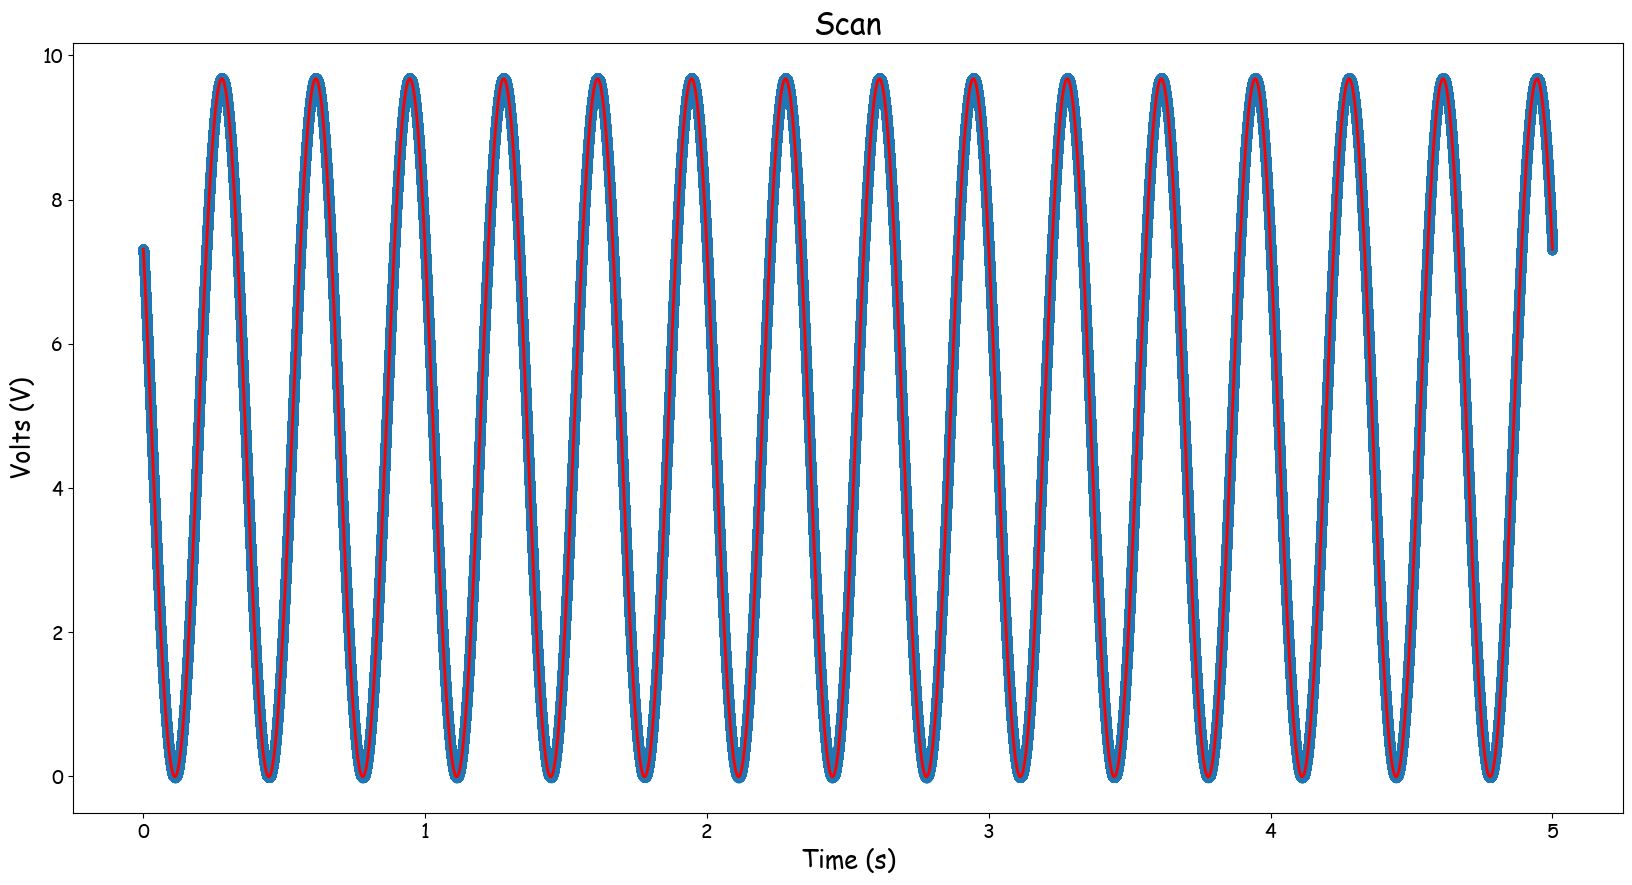

In [5]:
fig, ax = plt.subplots(figsize = (20,10))
# ax.plot(t, sine_wave(t, np.max(v)/2, 3, -3.7, 5), color = "r")
ax.plot(t, fitted["fitfunc"](t), "r-", label="y fit curve", linewidth=2)
print (fitted["amp"], fitted["omega"]/(2*np.pi))
ax.scatter(t,v)
ax.set_xlabel("Time (s)")
ax.set_ylabel("Volts (V)")
ax.set_title("Scan")
display(pd.DataFrame(fitted))
display(fitted)
# So my PZT drive voltage signal is:

las_scan["fitted_scan"] = fitted["fitfunc"](t)
display(las_scan)

In [586]:
def scan_delay(i,j,phi,dA):
    return (fitted["amp"]*dA*np.sin(fitted["omega"]*las_scan["Time"][i:j]+fitted["phase"]+phi)+fitted["offset"])


No handles with labels found to put in legend.
No handles with labels found to put in legend.


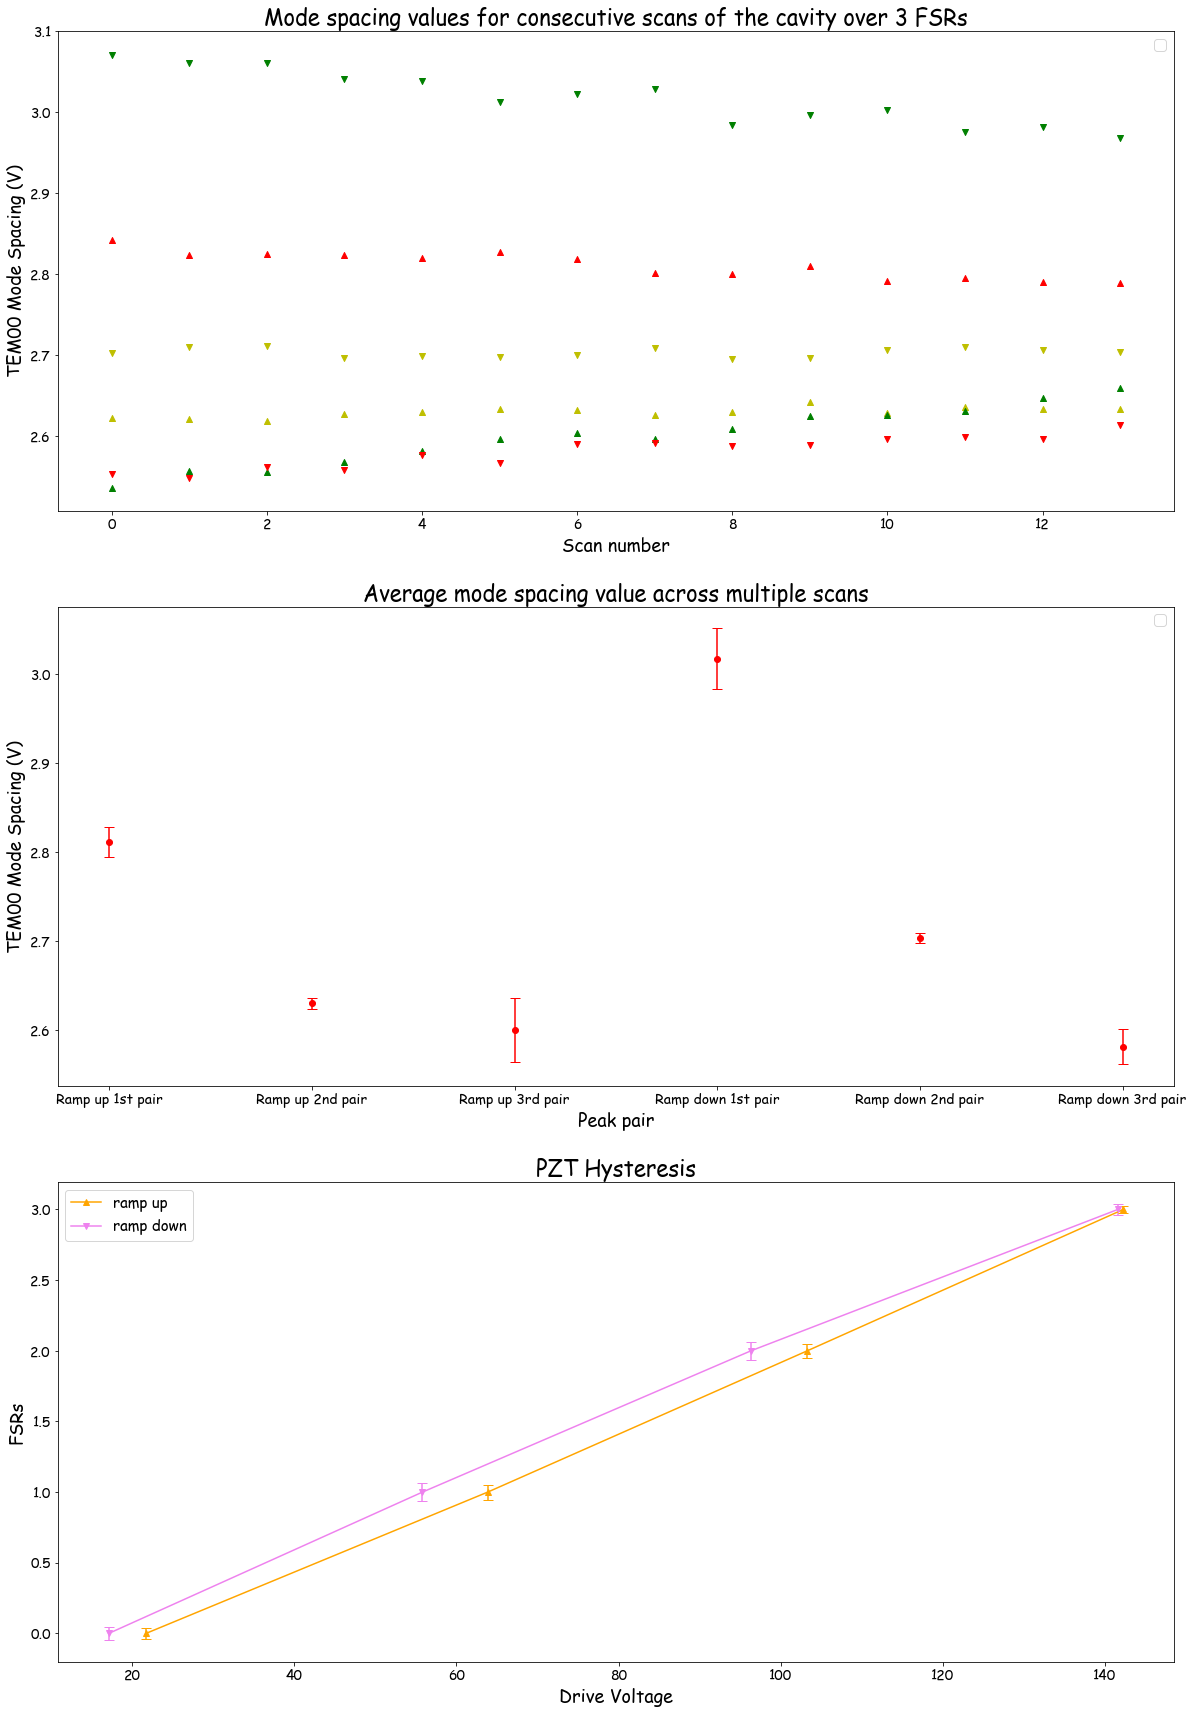

In [596]:
fig,ax = plt.subplots(3,1,figsize = (20,30))
for i in range(0,len(mode_spacings_up)):
    ax[0].scatter(i,mode_spacings_up[i][0], color = "r", marker ="^")
    ax[0].scatter(i,mode_spacings_up[i][1], color = "y", marker ="^")
    ax[0].scatter(i,mode_spacings_up[i][2], color = "g", marker ="^")
    
for i in range(0,len(mode_spacings_down)):
    ax[0].scatter(i,mode_spacings_down[i][0], color = "g", marker="v")
    ax[0].scatter(i,mode_spacings_down[i][1], color = "y",marker="v")
    ax[0].scatter(i,mode_spacings_down[i][2], color = "r",marker="v")    
ax[1].scatter(["Ramp up 1st pair","Ramp up 2nd pair","Ramp up 3rd pair","Ramp down 1st pair","Ramp down 2nd pair","Ramp down 3rd pair"],fsr_vals, color = "r")  
ax[1].errorbar(["Ramp up 1st pair","Ramp up 2nd pair","Ramp up 3rd pair","Ramp down 1st pair","Ramp down 2nd pair","Ramp down 3rd pair"],fsr_vals,yerr = [err_1_up, err_2_up, err_3_up, err_1_down,err_2_down,err_3_down],fmt='none', ecolor='red', capsize=5)  
ax[0].set_ylabel("TEM00 Mode Spacing (V)")
ax[0].set_title("Mode spacing values for consecutive scans of the cavity over 3 FSRs")
ax[0].set_xlabel("Scan number")
ax[1].set_ylabel("TEM00 Mode Spacing (V)")
ax[1].set_xlabel("Peak pair")
ax[1].set_title("Average mode spacing value across multiple scans")
applied_volts_up = np.array([np.mean([i[0] for i in volts_up]),
                 np.mean([i[1] for i in volts_up]),
                 np.mean([i[2] for i in volts_up]),
                 np.mean([i[3] for i in volts_up])])*15
applied_volts_down=np.array([np.mean([i[0] for i in volts_down]),
                     np.mean([i[1] for i in volts_down]),
                     np.mean([i[2] for i in volts_down]),
                     np.mean([i[3] for i in volts_down])])*15
ax[2].plot(applied_volts_up, [0,1,2,3], marker = "^", label = "ramp up", color = "orange")
ax[2].errorbar(applied_volts_up,[0,1,2,3],yerr = [np.std([i[0] for i in volts_up],ddof = 1), np.std([i[1] for i in volts_up],ddof = 1), np.std([i[2] for i in volts_up],ddof = 1),np.std([i[3] for i in volts_up],ddof = 1)],fmt='none', ecolor='orange', capsize=5)  
ax[2].plot(applied_volts_down, [3,2,1,0], marker = "v", label="ramp down", color = "violet")
ax[2].errorbar(applied_volts_down,[3,2,1,0],yerr = [np.std([i[0] for i in volts_down],ddof = 1),np.std([i[1] for i in volts_down],ddof = 1),np.std([i[2] for i in volts_down],ddof = 1),np.std([i[3] for i in volts_down],ddof = 1)],fmt='none', ecolor='violet', capsize=5)  
ax[2].set_xlabel("Drive Voltage")
ax[2].set_ylabel("FSRs")
ax[2].set_title("PZT Hysteresis")
ax[0].legend()
ax[1].legend()
ax[2].legend()



# Convert mode_spacings to a single array for averaging

Text(0, 0.5, 'Volts (V)')

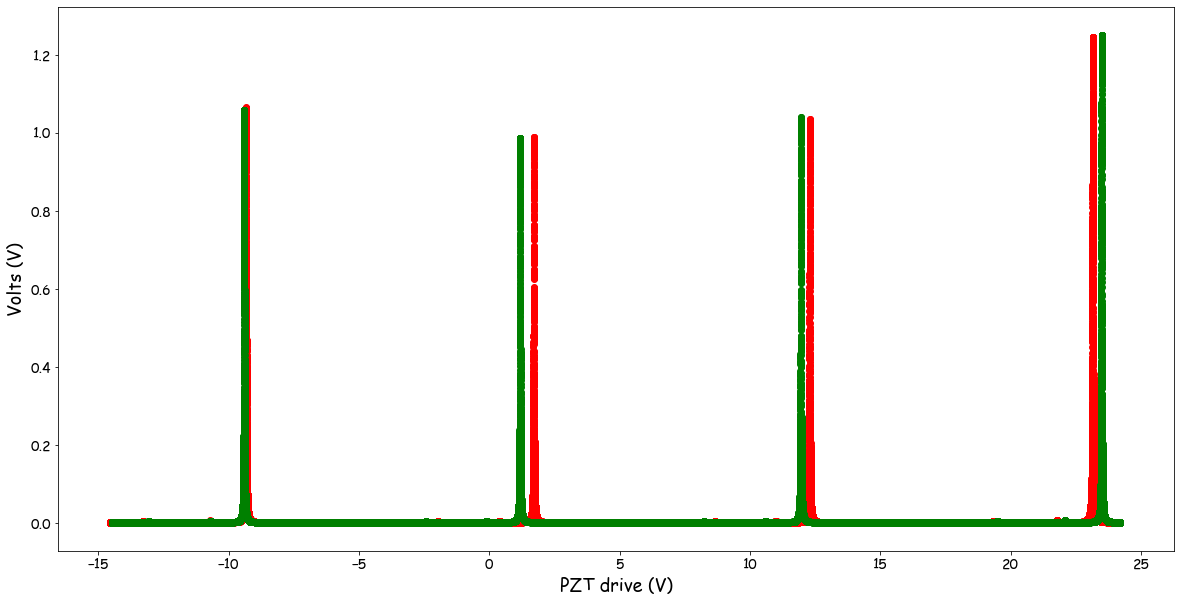

In [662]:
fig,ax = plt.subplots(figsize = (20,10))
# ax[0].scatter(np.array(las_scan["fitted_scan"].tolist())[0:833697],np.array(las_scan["pBeam"].tolist())[0:833697] )



def delay_values(args):
    phi,dA = args

    v1 = (fitted["amp"]*np.sin(fitted["omega"]*time_up[0][:2]+fitted["phase"]+phi)+fitted["offset"])+dA*np.cos(fitted["omega"]*time_up[0][:2]+fitted["phase"]+phi)
    v2 = (fitted["amp"]*np.sin(fitted["omega"]*time_down[0][1:3]+fitted["phase"]+phi)+fitted["offset"]) + dA*np.cos(fitted["omega"]*time_up[0][:2]+fitted["phase"]+phi)
    return np.sum((v1-np.sort(v2))**2)

# res = minimize(delay_values,[-0.1,0.8], bounds= [[-3.14,0],[0.1,1]])
# print (res)
manual = [-0.06,4]
ax.scatter(np.array(scan_delay(0,833697//2,manual[0],manual[1])).tolist(),np.array(las_scan["pBeam"].tolist())[0:833697//2], color = "r" )
ax.scatter(np.array(scan_delay(833697//2,833697,manual[0],manual[1])).tolist(),np.array(las_scan["pBeam"].tolist())[833697//2:833697], color = "g")
ax.set_xlabel("PZT drive (V)")
ax.set_ylabel("Volts (V)")
# ax[0].set_title("single full scan")

# Converting voltage axis to gamma 

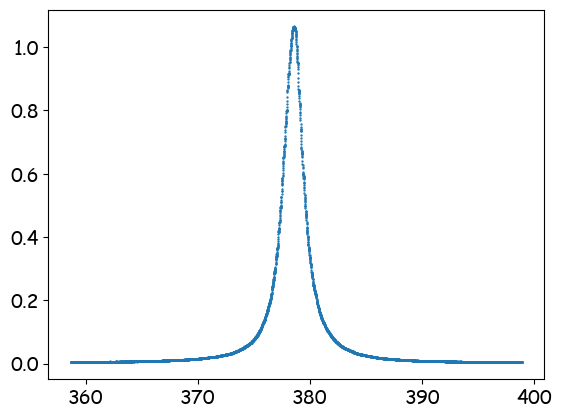

True


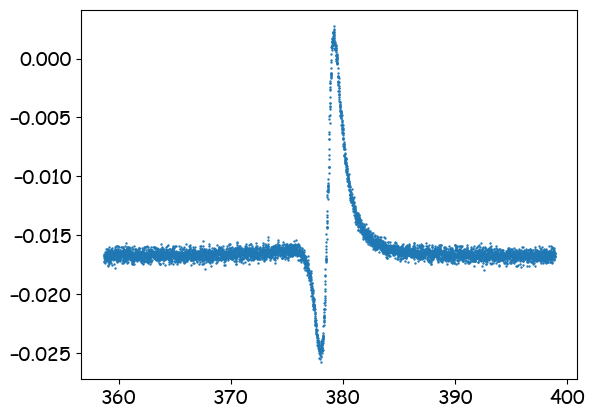

In [6]:
pd.options.mode.chained_assignment = None  # Disable the warning
trim = np.argmin(abs(las_scan_trimmed["fitted_scan"][0:833697//2]-volts_up[0][0]))
# there's no particular reason for calling this df peak1 and not just peak
peak1 = las_scan_trimmed.loc[trim-(6011/2) :trim+(6011/2)] # 6011 is the number of points i want- just like that

fwhm_volts =np.abs( peak1["fitted_scan"][peak1[peak1["err_sig"]==(np.max(peak1["err_sig"]))].index[0]]-peak1["fitted_scan"][peak1[peak1["err_sig"]==(np.min(peak1["err_sig"]))].index[0]])
gamma = fwhm_volts/2
FSR = mode_spacings_up[0][0] 
peak1["v"]= peak1["fitted_scan"]/(fwhm_volts/2) # factor half to normalise wrt to gamma
plt.scatter(peak1["v"], peak1["pBeam"], s=0.5)
plt.show()
plt.scatter(peak1["v"], peak1["signal"], s=0.5)
# sanity check
fwhm =np.abs( peak1["v"][peak1[peak1["err_sig"]==(np.max(peak1["err_sig"]))].index[0]]-peak1["v"][peak1[peak1["err_sig"]==(np.min(peak1["err_sig"]))].index[0]])
print (fwhm==2)

# Fitting the normalised loarentzian to the signal

In [20]:
import inspect
print(inspect.getsource(norm_L))
import inspect
print(inspect.getsource(sig_norm))

def norm_L(v,v0,A):
    return A/(1+((v-v0)**2))

def sig_norm(v, offset,del_v0, beta, del_A):
    v0,A = popt2
    return offset+ norm_L(v,v0,A)- ((A+del_A)/(1+(((1+beta)**2)*(v-(v0+del_v0))**2)))



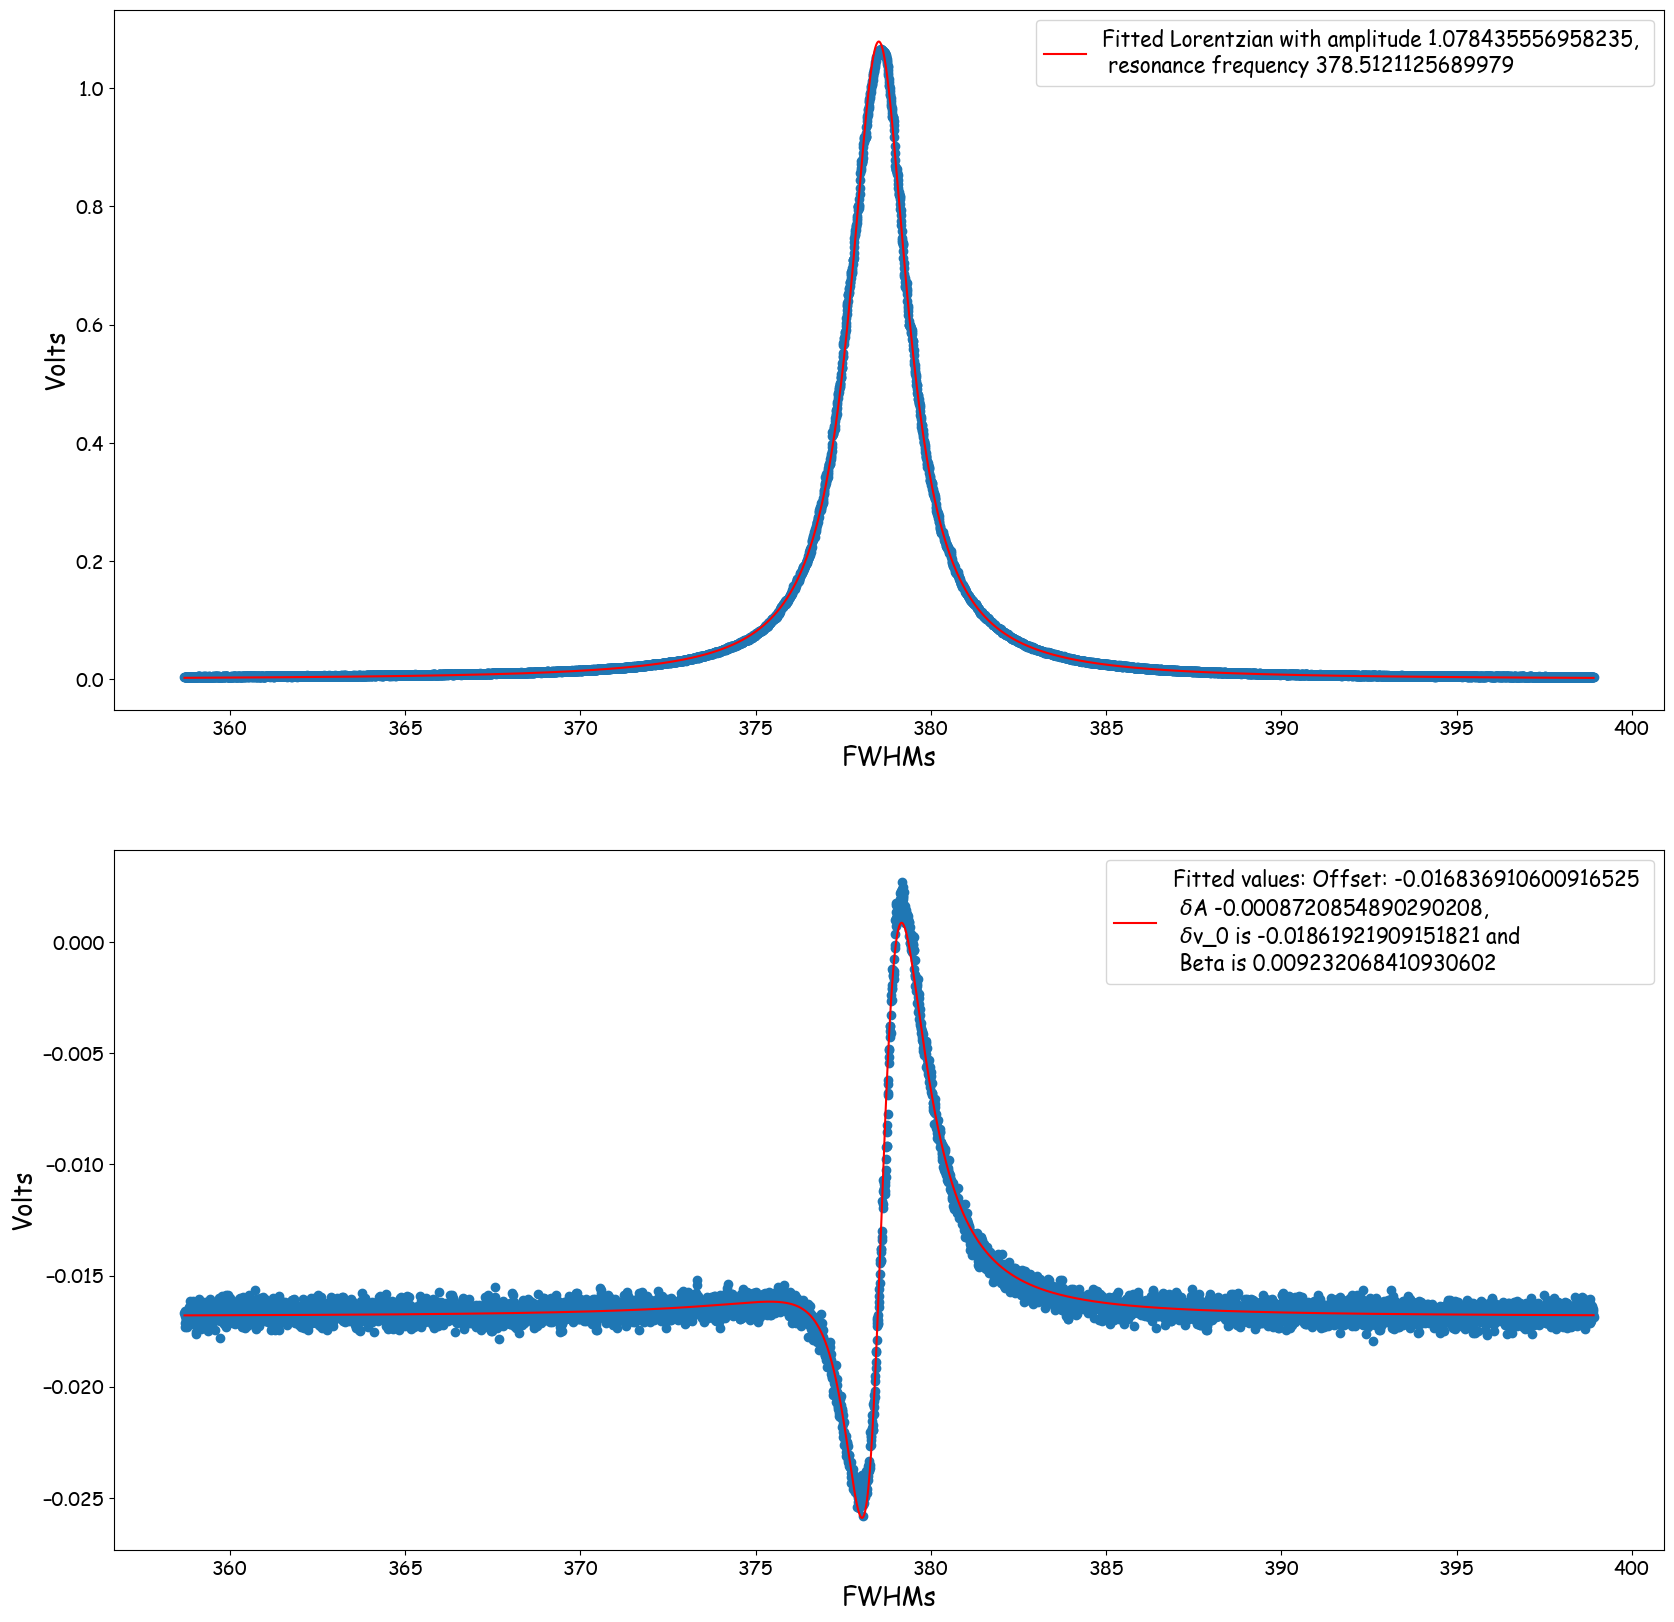

In [7]:
fig, ax = plt.subplots(2,1, figsize = (20,20))
ax[0].scatter(peak1["v"], peak1["pBeam"])
ax[1].scatter(peak1["v"], peak1["signal"])
ax[0].set_xlabel("FWHMs")
ax[1].set_xlabel("FWHMs")
ax[0].set_ylabel("Volts")
ax[1].set_ylabel("Volts")
# ax[0].set_xlim((135,150))
# ax[1].set_xlim((135,150))

# 2. Initial guess for the parameters [A, x0, gamma]
# initial_guess = [1, 142, 0.35]

# Wrapper function to pass individual parameters (v0, A) to curve_fit


initial_guess_2= [378,1.07]

# 3. Fit the Lorentzian curve to the data
# popt, pcov = curve_fit(lorentzian, peak1["freq"], peak1["pBeam"], p0=initial_guess)
popt2, pcov2 = curve_fit(norm_L, peak1["v"], peak1["pBeam"], p0=initial_guess_2)
perr2 = np.sqrt(np.diag(pcov2))
v0_fit2, A_fit2 = popt2


initial_guess_3 = [-0.015,0.085,0.01,0.001] 
# bounds = ([-0.02, -0.042, -0.2, -0.002],[-0.014, 0, 0, 0])
# x0_fit3, gamma_fit3, A_fit3 = popt3
 # this is input to the sig_norm function
def sig_norm(v, offset,del_v0, beta, del_A):
    v0,A = popt2
    return offset+ norm_L(v,v0,A)- ((A+del_A)/(1+(((1+beta)**2)*(v-(v0+del_v0))**2)))
popt3, pcov3 = curve_fit(sig_norm, peak1["v"], peak1["signal"])
offset, del_v0, beta, del_A = popt3
# ax[0].plot(peak1["freq"], lorentzian(peak1["freq"], *popt), label=f'Fitted Lorentzian with amplitude {A_fit}, \n resonance frequency {x0_fit} and \n FWHM {2*gamma_fit}', color='g')
ax[0].plot(peak1["v"], norm_L(np.array(peak1["v"]), *popt2), label=f'Fitted Lorentzian with amplitude {A_fit2}, \n resonance frequency {v0_fit2}', color='r')
# ax[0].plot(peak1["freq"], L_2(peak1["freq"], *popt3), label=f'Fitted Lorentzian with amplitude {A_fit3}, \n resonance frequency {x0_fit3} and \n FWHM {2*gamma_fit3}', color='orange')
ax[0].legend()
ax[1].plot(peak1["v"],sig_norm(peak1["v"], *popt3) , label=f'Fitted values: Offset: {popt3[0]} \n $\delta$A {popt3[3]}, \n $\delta$v_0 is {popt3[1]} and \n Beta is {popt3[2]} ', color='r')
ax[1].legend()

In [89]:
perr3 = np.sqrt(np.diag(pcov3))
print (perr3[2]*100/beta)


0.02642085224805673


# Creating separate arrays for all the peaks 

In [127]:
peaks = []
signals =[]
freqs = []
n = len(las_scan_trimmed["signal"])/(14)
for i in range(0,14):
    for j in range(0,4):
        trim_up = np.argmin(abs(las_scan_trimmed["fitted_scan"][i*n:i*n+n/2]-volts_up[i][j]))
        trim_down = np.argmin(abs(las_scan_trimmed["fitted_scan"][i*n+n/2:(i+1)+n]-volts_down[i][j]))
        peak1_up = las_scan_trimmed.loc[trim_up-(6011/2) :trim_up+(6011/2)] # 6011 is the number of points i want- just like that
        peak1_down= las_scan_trimmed.loc[trim_down-(6011/2) :trim_down+(6011/2)] # 6011 is the number of points i want- just like that
        if j == 3:
            peak_up = peak1_up
            peak_down= peak1_down
            peak_up["freq"]=peak1_up["fitted_scan"]*FSR/mode_spacings_up[i][j-1] # this is because mode spacing has only 3 elements
            peak_down["freq"] = peak1_down["fitted_scan"]*FSR/mode_spacings_down[i][j-1]
        else:
            peak1["freq"]=peak1["fitted_scan"]*FSR/mode_spacings_up[i][j]
        peak1 = peak1.reset_index(drop=True)
        freqs.append(peak1["freq"])
        peaks.append(peak1["pBeam"])
        signals.append(peak1["signal"])
               
print (peaks)



/var/folders/gm/ptgrnkqx1k19rf9djd0hxwww0000gn/T/ipykernel_90631/3688726611.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  peak1["freq"]=peak1["fitted_scan"]*FSR/mode_spacings_up[i][j]
/var/folders/gm/ptgrnkqx1k19rf9djd0hxwww0000gn/T/ipykernel_90631/3688726611.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  peak1["freq"]=peak1["fitted_scan"]*FSR/mode_spacings_up[i][j]
/var/folders/gm/ptgrnkqx1k19rf9djd0hxwww0000gn/T/ipykernel_90631/3688726611.py:12: SettingWithCopyWarning: 
A value is trying to b

IndexError: list index out of range

## Let's look at error signal and calibrate time to frequency axis with that.

0.00011959999999999749


,Time,err_sig,signal,pBeam,scan,fitted_scan


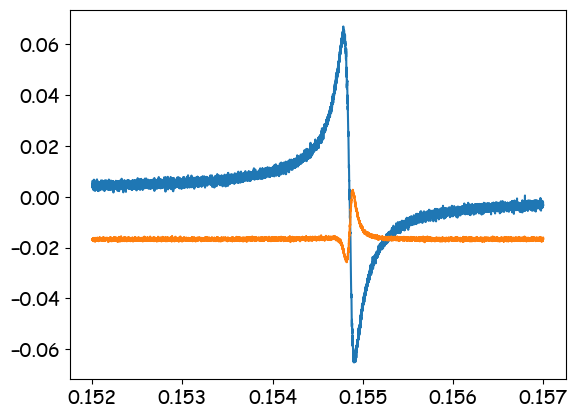

In [156]:
trim = las_scan.loc[:833697//2]
trim = trim.reset_index(drop=True)
trim = trim.loc[np.argmin(np.abs(trim["Time"]-0.152)):np.argmin(np.abs(trim["Time"]-0.157))]

temporal_fwhm =(trim.iloc[np.argmin(np.abs(trim["err_sig"]- np.min(trim["err_sig"])))]["Time"]-
      trim.iloc[np.argmin(np.abs(trim["err_sig"]- np.max(trim["err_sig"])))]["Time"])
       
# Now this is the lenewidth of the cavity.

plt.plot(trim["Time"],trim["err_sig"] )
plt.plot(trim["Time"],trim["signal"] )

signal_1 = choose.loc[np.argmin(abs(choose["Time"]-0.15)):np.argmin(abs(choose["Time"]-0.16))]
display(signal_1) 

KeyError: 'freq'

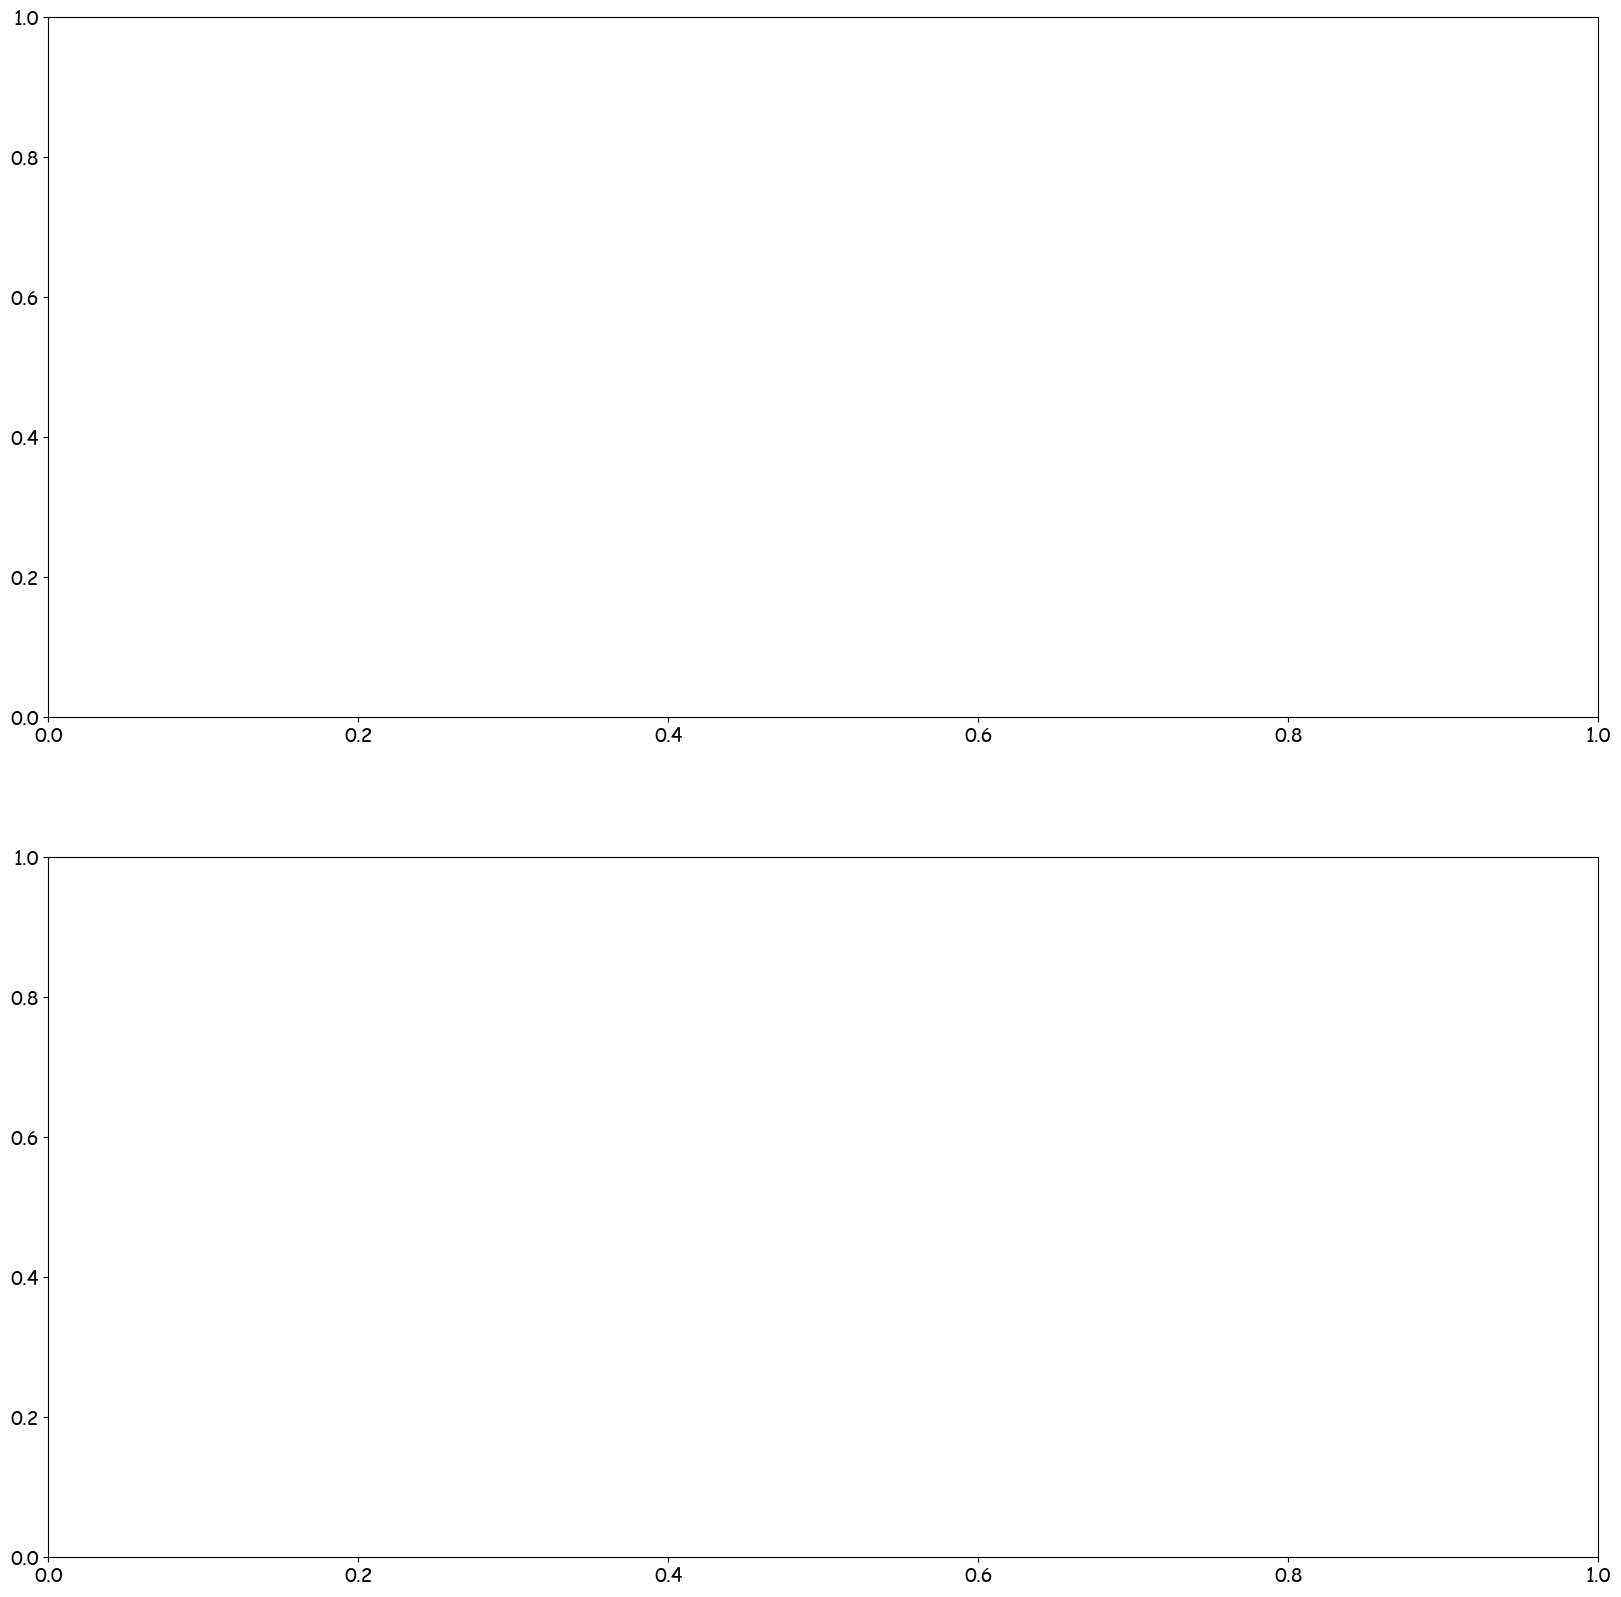

In [223]:
fig, ax = plt.subplots(2,1, figsize = (20,20))
ax[0].scatter(peak1["freq"], peak1["pBeam"])
ax[1].scatter(peak1["freq"], peak1["signal"])
ax[0].set_xlabel("Freq (MHz)")
ax[1].set_xlabel("Freq (MHz)")
ax[0].set_ylabel("Volts")
ax[1].set_ylabel("Volts")
# ax[0].set_xlim((135,150))
# ax[1].set_xlim((135,150))

# 2. Initial guess for the parameters [A, x0, gamma]
# initial_guess = [1, 142, 0.35]
initial_guess_2= [142, 0.35, 1]

# 3. Fit the Lorentzian curve to the data
# popt, pcov = curve_fit(lorentzian, peak1["freq"], peak1["pBeam"], p0=initial_guess)
popt2, pcov2 = curve_fit(L, peak1["freq"], peak1["pBeam"], p0=initial_guess_2)

perr2 = np.sqrt(np.diag(pcov2))



# popt3, pcov3 = curve_fit(L_2, peak1["freq"], peak1["pBeam"], p0=initial_guess_2)

# Extract the optimal parameters
# A_fit, x0_fit, gamma_fit = popt
f0_fit2, gamma_fit2, A_fit2 = popt2

initial_guess_3 = [-0.015,30e-3,2.8979238754325258e-05,0.1]
# x0_fit3, gamma_fit3, A_fit3 = popt3
popt3, pcov3 = curve_fit(sig_L, peak1["freq"], peak1["signal"], p0=initial_guess_3)
offset, f0_fit3, gamma_fit3, A_fit3 = popt3
# ax[0].plot(peak1["freq"], lorentzian(peak1["freq"], *popt), label=f'Fitted Lorentzian with amplitude {A_fit}, \n resonance frequency {x0_fit} and \n FWHM {2*gamma_fit}', color='g')
ax[0].plot(peak1["freq"], L(peak1["freq"], *popt2), label=f'Fitted Lorentzian with amplitude {A_fit2}, \n resonance frequency {f0_fit2} and \n FWHM {2*gamma_fit2}', color='r')
# ax[0].plot(peak1["freq"], L_2(peak1["freq"], *popt3), label=f'Fitted Lorentzian with amplitude {A_fit3}, \n resonance frequency {x0_fit3} and \n FWHM {2*gamma_fit3}', color='orange')

ax[0].legend()
ax[1].plot(peak1["freq"], sig_L(peak1["freq"], *popt3), label=f'Fitted delta A {A_fit3}, \n delta f {f0_fit3*10**3} kHz and \n delta FWHM {2*gamma_fit3*10**3} kHz', color='r')

ax[1].legend()

In [8]:
perr2 = np.sqrt(np.diag(pcov2))
print (perr2)
perr3 = np.sqrt(np.diag(pcov3))
print (perr3)
print ("error in del f_0 is", perr3[1]*1e3, "kHz")
print ("error in del del_gamma is", perr3[2]*1e3, "kHz")
print ("error in del del_A is", perr3[3])


[0.00042104 0.00032108]
[6.09142245e-06 3.43413853e-05 5.36303867e-05 3.73572714e-05]
error in del f_0 is 0.034341385266572565 kHz
error in del del_gamma is 0.05363038665277186 kHz
error in del del_A is 3.735727139530017e-05


# Splitting the signal into three different basis

A Lorentzian can be expressed as:
 $$ L = \frac{A \gamma }{\pi  \left(\gamma
   ^2+(f-{f_0})^2\right)} $$
   
where $ \gamma $ is the HWHM, $A$ is the amplitude and $f_0$ is the resonance frequency. 

Difference between two lorentzians can be expressed as with different resonance frequencies, HWHMs and amplitudeds is simply:

$$
\frac{A \gamma }{\pi  \left((f-{f_0})^2+\gamma^2\right)}-\frac{{A'} {\gamma'}}{\pi\left((f-{f_0'})^2+{\gamma'}^2\right)}
$$

But to a first order approximation this can be expressed as a linear combination of the following fucntions:

$$
\delta A \times L +  \delta f_0 \times \frac{dL}{df} + \delta \gamma/ \gamma \times f \times \frac{dL}{df}
$$


The first expression represents the amplitude difference between the two resonances, the second expression the the derivative of a lorentzian and it represents the difference the resonance frequencies and the third expression is the secodn derivative of the lorentzian and it represents the difference in the finesse or HWHMs of the two resoanance peaks in an optical cavity.

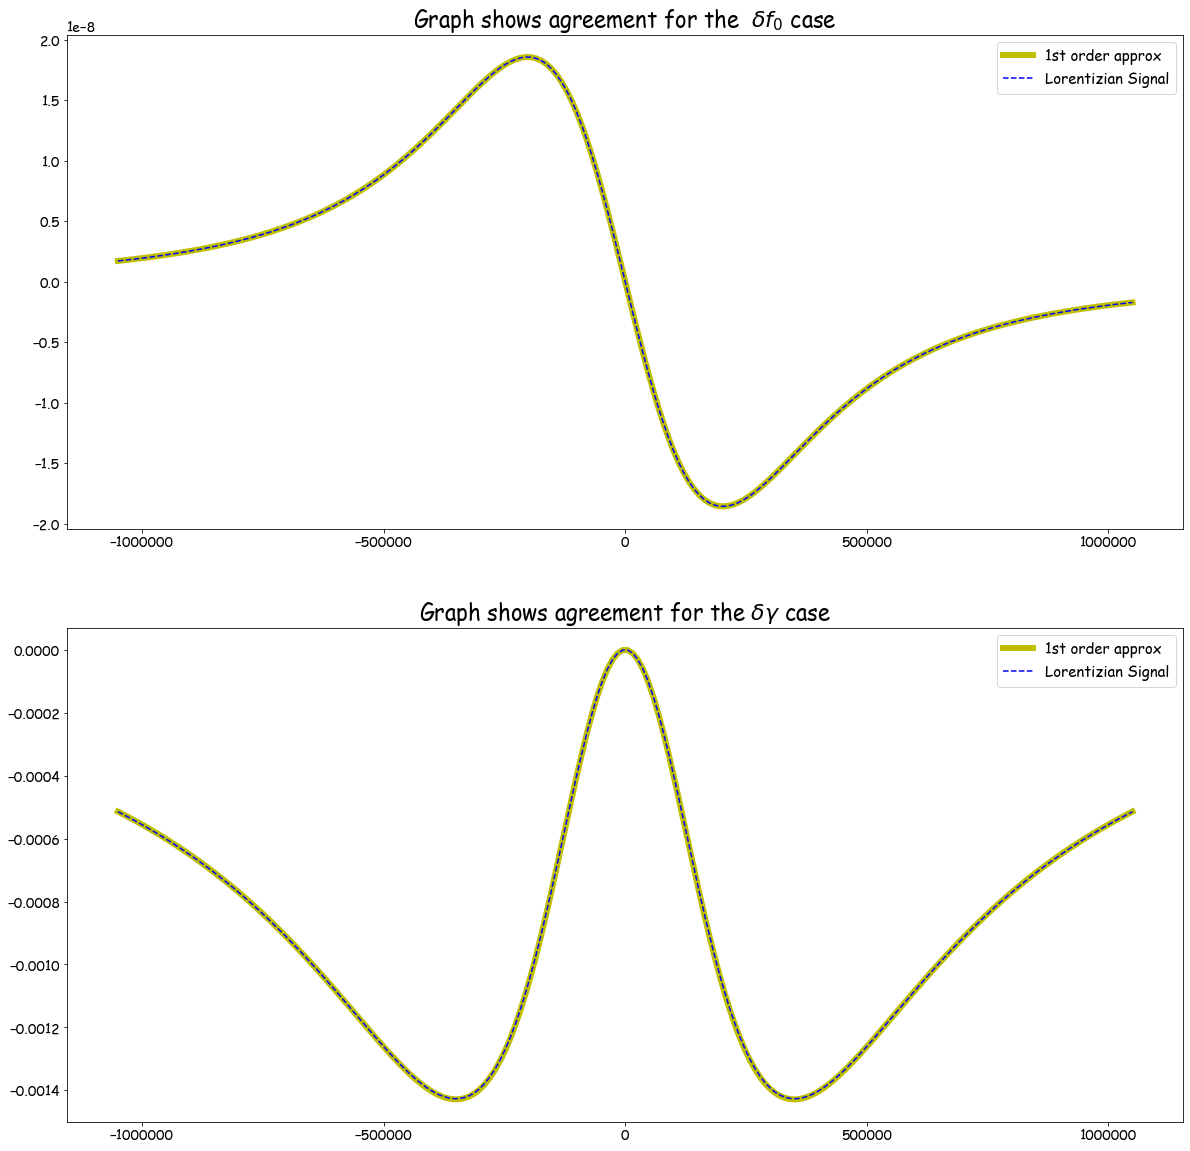

<Figure size 1440x720 with 0 Axes>

In [658]:
fig, ax  =plt.subplots(2,1, figsize =(20,20))
A = 1
gamma = 700e3/2
df = 0.01
dgamma = 1e3
f = np.linspace(-3*gamma,3*gamma,200)
plt.figure(figsize = (20,10))

ax[0].plot(f,df*dLdf(f,0,gamma,A),linestyle= "-", color = "y", linewidth =6, label ="1st order approx")
ax[0].plot(f,L(f,0,gamma,A)-L(f,df,gamma,A), linestyle = "--", color = "b", label ="Lorentizian Signal")

ax[1].plot(f, dgamma*f*dLdf(f,0,gamma,A)/gamma,linestyle= "-", color = "y", linewidth =6, label ="1st order approx")
ax[1].plot(f,L(f,0,gamma,A)-L(f,0,gamma+dgamma,A), linestyle = "--", color = "b", label ="Lorentizian Signal")

ax[0].set_title("Graph shows agreement for the  $\delta f_0$ case")
ax[1].set_title("Graph shows agreement for the $\delta \gamma$ case")
ax[0].legend()
ax[1].legend()
# def fit_func(x,da1,da2,da3):
#     return d2Ldx2(xx,0,1)*da1+da2*dLdx(xx,0,1)+da3*L(xx,0,1)

# Using MCMC

In [266]:
# define the bounds on the uniform prior for each of the parameters
prior_bounds = [
    [140,144],# f01
    [0.2,1],# gamma1
    [0.8,10], # A1
    [140,144], # f02
    [0.2,1], # gamma2
    [0.8,10], # A2
    [1e-10,0.05], # sigma
    [-0.02, -0.01]
]


In [267]:
# Set up the MCMC sampler
n_walkers = 100 # number of chains or walkers
n_dim = len(prior_bounds)  # Number of parameters [A1, x1, gamma1, A2, x2, gamma2]
n_steps = 10000 # number of samples at the end
n_tune = 2000

# start wakers in positions drawn from the prior. i.e. sample parameters from a uniform distribution
initial_pos = uniform_prior_sample(n_walkers, prior_bounds)

In [106]:
print (initial_pos[0])

[1.43785581e+02 8.90259663e-01 7.59533515e+00 1.41337431e+02
 7.70137872e-01 2.11360077e+00 1.29080269e-02]


In [268]:
# Run the MCMC
sampler = emcee.EnsembleSampler(n_walkers, n_dim, log_posterior, args=(peak1["freq"], peak1["signal"], prior_bounds))
# Run the tuning phase
output = sampler.run_mcmc(initial_pos, n_steps, progress=True, tune=n_tune)

NameError: name 'emcee' is not defined

In [108]:
print("Acceptance fraction:", np.mean(sampler.acceptance_fraction))
autocorr = sampler.get_autocorr_time()
print("Autocorrelation times:", autocorr)

Acceptance fraction: 0.2187625
Autocorrelation times: [ 1.  1. nan nan  1.  1. nan]


/opt/anaconda3/lib/python3.7/site-packages/emcee/autocorr.py:38: RuntimeWarning: invalid value encountered in true_divide
  acf /= acf[0]
/opt/anaconda3/lib/python3.7/site-packages/emcee/autocorr.py:43: RuntimeWarning: invalid value encountered in less
  m = np.arange(len(taus)) < c * taus
/opt/anaconda3/lib/python3.7/site-packages/emcee/autocorr.py:109: RuntimeWarning: invalid value encountered in greater
  flag = tol * tau_est > n_t


In [109]:
# skip over first 5000 parameter as mcmc is still searching
samples = sampler.get_chain(discard=1700, thin=1, flat=True)

In [110]:
samples2 = sampler.get_chain(discard=0, thin=1)
samples2.shape

(10000, 16, 7)

Text(0.5, 0, 'Step number')

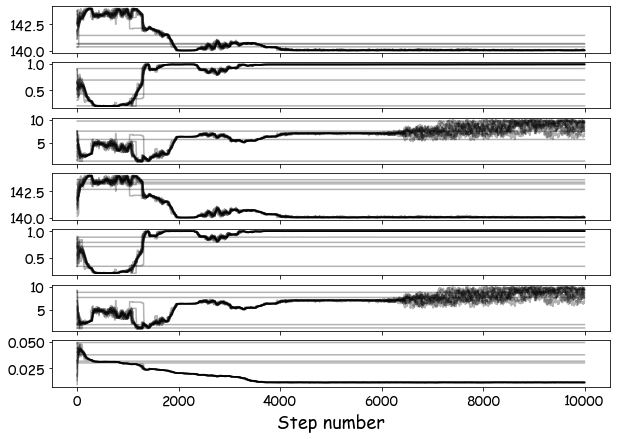

In [111]:
fig, axes = plt.subplots(n_dim, figsize=(10, 7), sharex=True)
for i in range(n_dim):
    ax = axes[i]
    ax.plot(samples2[0:,:, i], "k", alpha=0.3)
#     ax.set_ylabel(f"{labels[i]}")
axes[-1].set_xlabel("Step number")

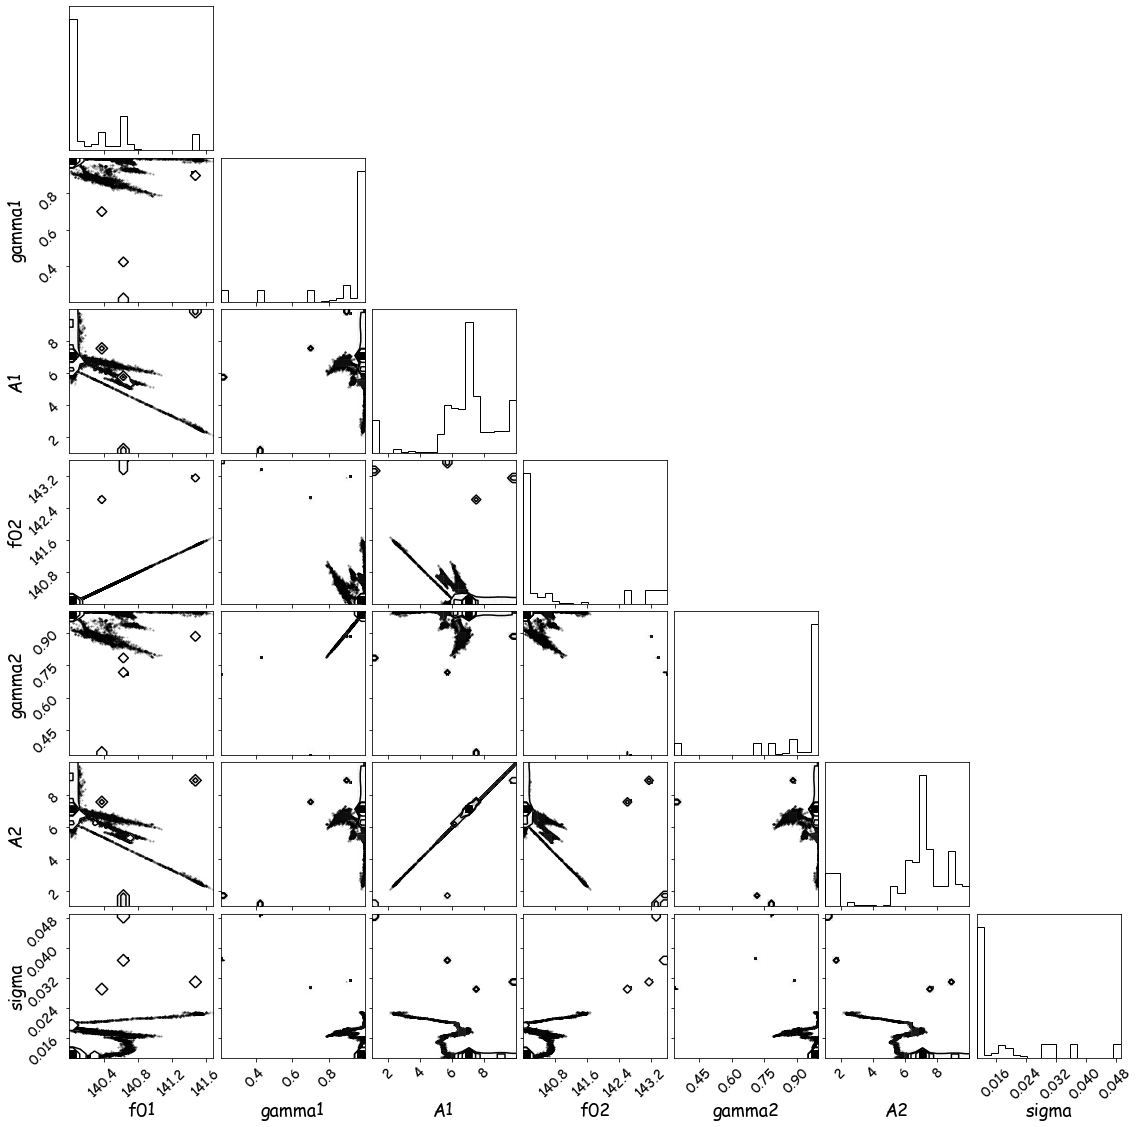

In [112]:
labels = [ "f01", "gamma1","A1","f02", "gamma2", "A2" , "sigma"]
fig = corner.corner(samples, labels=labels)
ndim = samples.shape[1]
axes = np.array(fig.axes).reshape((ndim, ndim))
# for i in range(ndim):
#     for j in range(i):
#         # Add true values as blue squares
#         axes[i, j].plot(max_likelihood[j], max_likelihood[i], color="r", marker="x", label='Max likelihood')
plt.show()

# Numpyro

/var/folders/gm/ptgrnkqx1k19rf9djd0hxwww0000gn/T/ipykernel_90631/1999386773.py:52: UserWarning: There are not enough devices to run parallel chains: expected 4 but got 1. Chains will be drawn sequentially. If you are running MCMC in CPU, consider using `numpyro.set_host_device_count(4)` at the beginning of your program. You can double-check how many devices are available in your system using `jax.local_device_count()`.
  numpyro_sampler = MCMC(nuts_kernel, num_warmup=1000, num_samples=4000, num_chains=4)
sample: 100%|█| 5000/5000 [03:24<00:00, 24.44it/s, 1023 steps of size 3.26e-06. 
sample: 100%|█| 5000/5000 [03:25<00:00, 24.29it/s, 1023 steps of size 1.96e-05. 
sample: 100%|█| 5000/5000 [01:50<00:00, 45.22it/s, 255 steps of size 2.02e-03. a
sample: 100%|█| 5000/5000 [03:23<00:00, 24.62it/s, 1023 steps of size 1.32e-05. 


<function matplotlib.pyplot.show(close=None, block=None)>

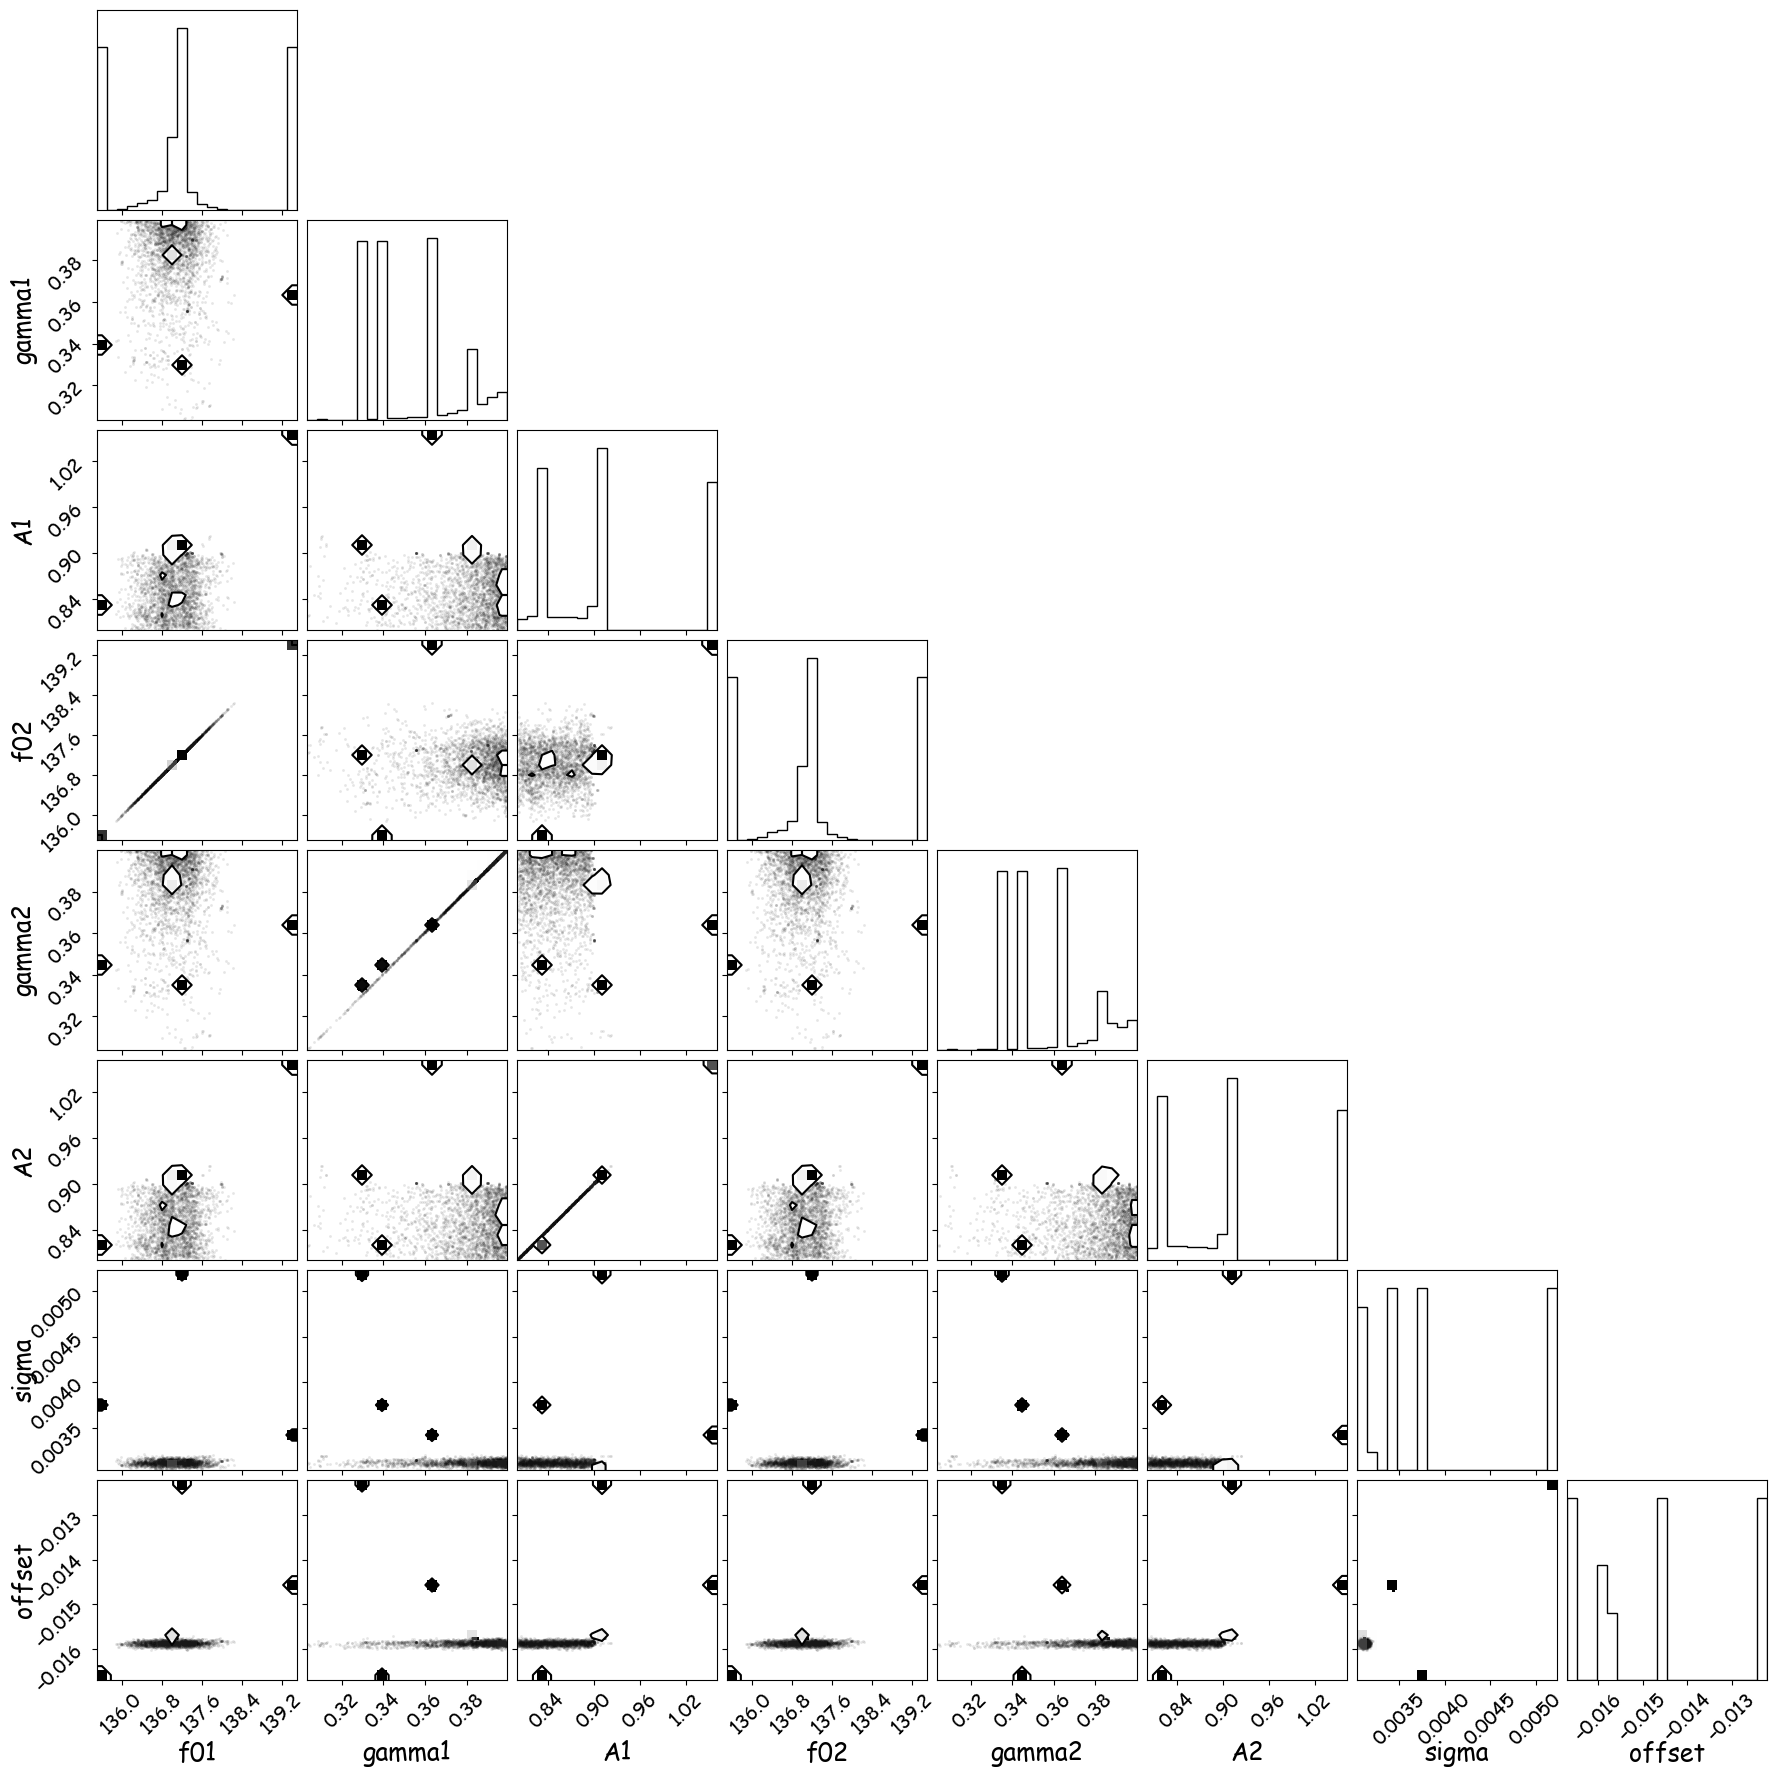

In [27]:
# define the bounds on the uniform prior for each of the parameters
prior_bounds = [
    [135.5,142],# f01
    [0.3,0.4],# gamma1
    [0.8,1.2], # A1
    [135.5,142], # f02
    [0.3,0.4], # gamma2
    [0.8,1.2], # A2
    [1e-10,0.05], # sigma
    [-0.02,-0.01]# offset
]

def signal_model(theta, freq):
    """Signal model which is the subtraction of two lorentzian distributions

    Args:
        theta (_type_): signal parameters
        freq (_type_): frequencies of data points 

    Returns:
        _type_: _description_
    """
    offset, f01, gamma1, A1, f02, gamma2, A2 = theta
    L1 = L(freq,f01,gamma1, A1)
    L2 = L(freq,f02,gamma2, A2)
    return offset+ L1-L2

def L(f,f0,gamma,A=1):
    return A/(1+(f-f0)**2/(gamma**2))

def numpyro_model(frequencies, prior_bounds ,observed_data=None):
    # Priors for the parameters
    A1 = numpyro.sample('A1', dist.Uniform(prior_bounds[2, 0], prior_bounds[2, 1]))
    f01 = numpyro.sample('f01', dist.Uniform(prior_bounds[0, 0], prior_bounds[0, 1]))
    gamma1 = numpyro.sample('gamma1', dist.Uniform(prior_bounds[1, 0], prior_bounds[1, 1]))
    A2 = numpyro.sample('A2', dist.Uniform(prior_bounds[5, 0], prior_bounds[5, 1]))
    f02 = numpyro.sample('f02', dist.Uniform(prior_bounds[3, 0],f01))
    gamma2 = numpyro.sample('gamma2', dist.Uniform(prior_bounds[4, 0], prior_bounds[4, 1]))
    sigma = numpyro.sample('sigma', dist.Uniform(prior_bounds[6, 0], prior_bounds[6, 1]))
    offset = numpyro.sample("offset", dist.Uniform(prior_bounds[7,0],prior_bounds[7,1]))


    # Signal model
    model_y = signal_model([offset, f01, gamma1,A1, f02, gamma2, A2], frequencies)
    
    # Likelihood
    with numpyro.plate('data', len(frequencies)):
        numpyro.sample('obs', dist.Normal(model_y, sigma), obs=observed_data)

rng_key = random.PRNGKey(0)
nuts_kernel = NUTS(numpyro_model)
numpyro_sampler = MCMC(nuts_kernel, num_warmup=1000, num_samples=4000, num_chains=4)
numpyro_sampler.run(rng_key, frequencies=jnp.array(peak1["freq"]), prior_bounds=np.array(prior_bounds), observed_data=jnp.array(peak1["signal"]))

labels = [ "f01", "gamma1","A1","f02", "gamma2", "A2" , "sigma", "offset"]
posterior_samples = numpyro_sampler.get_samples()
posterior_array = np.array([posterior_samples[param] for param in labels])
posterior_array = posterior_array.T.reshape(-1, len(posterior_samples.keys()))

fig = corner.corner(posterior_array, labels=labels)
plt.show

In [231]:
print (np.min(posterior_samples["f01"]))

140.5


# Fitting only Lorentzian 

/var/folders/gm/ptgrnkqx1k19rf9djd0hxwww0000gn/T/ipykernel_90631/324690840.py:46: UserWarning: There are not enough devices to run parallel chains: expected 4 but got 1. Chains will be drawn sequentially. If you are running MCMC in CPU, consider using `numpyro.set_host_device_count(4)` at the beginning of your program. You can double-check how many devices are available in your system using `jax.local_device_count()`.
  numpyro_sampler = MCMC(nuts_kernel, num_warmup=1000, num_samples=1000, num_chains=4)
sample: 100%|█| 2000/2000 [00:03<00:00, 551.65it/s, 15 steps of size 5.37e-02. a
sample: 100%|█| 2000/2000 [00:01<00:00, 1048.88it/s, 31 steps of size 4.47e-02. 
sample: 100%|█| 2000/2000 [00:01<00:00, 1088.57it/s, 19 steps of size 5.18e-02. 
sample: 100%|█| 2000/2000 [00:01<00:00, 1077.61it/s, 3 steps of size 4.76e-02. a


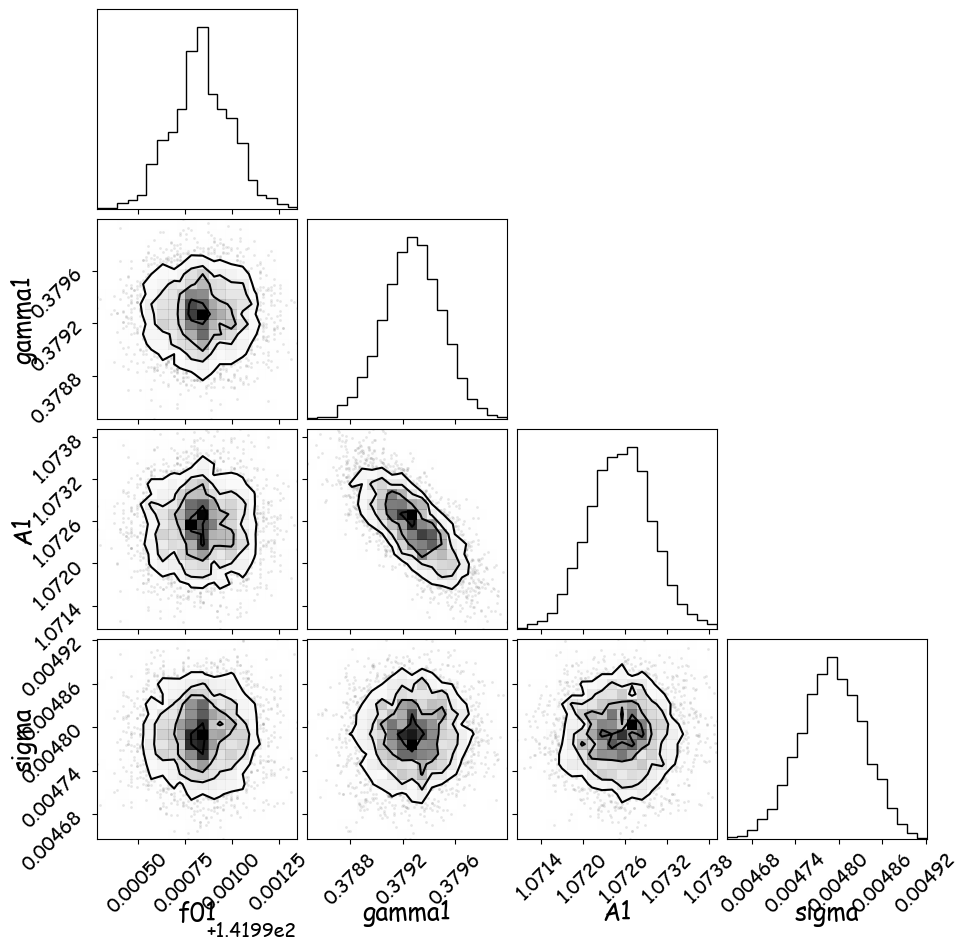

In [14]:
# define the bounds on the uniform prior for each of the parameters
prior_bounds = [
    [140,144],# f01
    [0.2,3],# gamma1
    [0.8,20], # A1
    [1e-10,0.05] # sigma
]
def L(f,f0,gamma,A=1):
    return A/(1+(f-f0)**2/gamma**2)

def signal_model(theta, freq):
    """Signal model which is the subtraction of two lorentzian distributions

    Args:
        theta (_type_): signal parameters
        freq (_type_): frequencies of data points 

    Returns:
        _type_: _description_
    """
    f01, gamma1, A1 = theta
    L1 = L(freq,f01,gamma1, A1)
    return L1



def numpyro_model(frequencies, prior_bounds ,observed_data=None):
    # Priors for the parameters
    A1 = numpyro.sample('A1', dist.Uniform(prior_bounds[2, 0], prior_bounds[2, 1]))
    f01 = numpyro.sample('f01', dist.Uniform(prior_bounds[0, 0], prior_bounds[0, 1]))
    gamma1 = numpyro.sample('gamma1', dist.Uniform(prior_bounds[1, 0], prior_bounds[1, 1]))

    sigma = numpyro.sample('sigma', dist.Uniform(prior_bounds[3, 0], prior_bounds[3, 1]))


    # Signal model
    model_y = signal_model([f01, gamma1,A1], frequencies)
    
    # Likelihood
    with numpyro.plate('data', len(frequencies)):
        numpyro.sample('obs', dist.Normal(model_y, sigma), obs=observed_data)
        
        
rng_key = random.PRNGKey(0)
nuts_kernel = NUTS(numpyro_model)
numpyro_sampler = MCMC(nuts_kernel, num_warmup=1000, num_samples=1000, num_chains=4)
numpyro_sampler.run(rng_key, frequencies=jnp.array(peak1["freq"]), prior_bounds=np.array(prior_bounds), observed_data=jnp.array(peak1["pBeam"]))

labels = [ "f01", "gamma1","A1" , "sigma"]
posterior_samples = numpyro_sampler.get_samples()
posterior_array = np.array([posterior_samples[param] for param in labels])
posterior_array = posterior_array.T.reshape(-1, len(posterior_samples.keys()))

fig = corner.corner(posterior_array, labels=labels)
plt.show()

# Running MC on the Signal 

/var/folders/gm/ptgrnkqx1k19rf9djd0hxwww0000gn/T/ipykernel_90631/3688911938.py:52: UserWarning: There are not enough devices to run parallel chains: expected 4 but got 1. Chains will be drawn sequentially. If you are running MCMC in CPU, consider using `numpyro.set_host_device_count(4)` at the beginning of your program. You can double-check how many devices are available in your system using `jax.local_device_count()`.
  numpyro_sampler = MCMC(nuts_kernel, num_warmup=1000, num_samples=2000, num_chains=4)
sample: 100%|█| 3000/3000 [01:12<00:00, 41.44it/s, 1023 steps of size 3.58e-05. 
sample: 100%|█| 3000/3000 [00:28<00:00, 107.07it/s, 511 steps of size 6.75e-03. 
sample: 100%|█| 3000/3000 [01:09<00:00, 43.09it/s, 255 steps of size 3.02e-04. a
sample: 100%|█| 3000/3000 [01:09<00:00, 43.01it/s, 1023 steps of size 1.59e-04. 


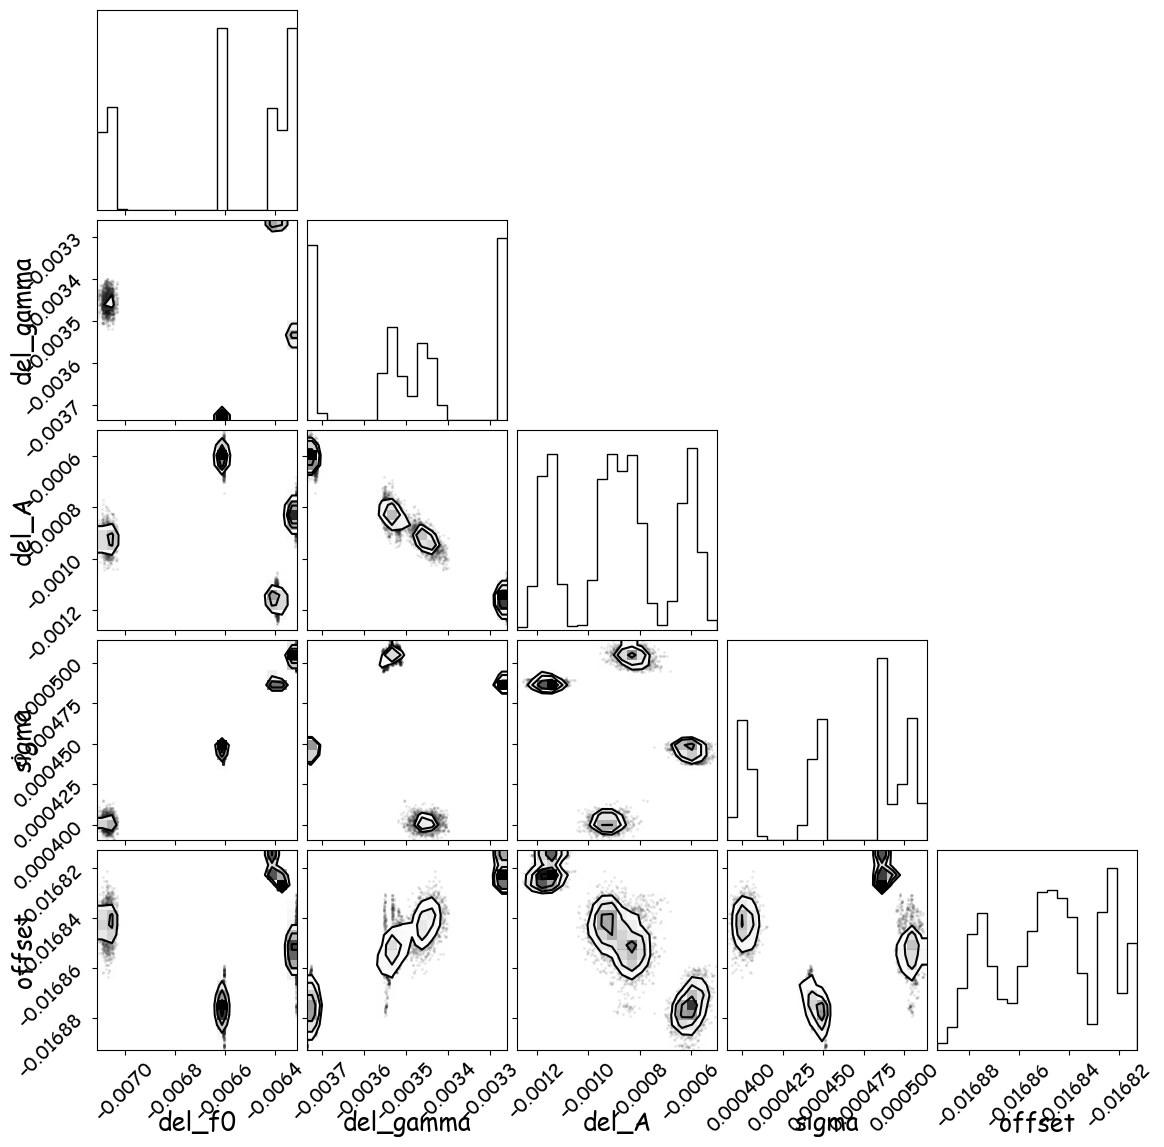

In [22]:
# define the bounds on the uniform prior for each of the parameters
prior_bounds = [
    [-8e-3,-6e-3],# deltaf01
    [-4e-3,-3e-3],# deltagamma1
    [-1,1], # deltaA1
    [1e-10,0.05], # sigma
    [-0.02,-0.01] #offset
]
def L(f,f0,gamma,A=1):
    return A/(1+(f-f0)**2/gamma**2)
def sig_L(f, offset, del_f0, del_gamma, del_A):
    f = peak1["freq"]
    return offset+ L(f, f0_fit2, gamma_fit2, A_fit2)-L(f,f0_fit2+del_f0,gamma_fit2+del_gamma, A_fit2+del_A)

def signal_model(theta, freq):
    """Signal model which is the subtraction of two lorentzian distributions

    Args:
        theta (_type_): signal parameters
        freq (_type_): frequencies of data points 

    Returns:
        _type_: _description_
    """
    del_f0, del_gamma, del_A, offset = theta
    sig = offset+ L(freq,f0_ro , gamma_ro, A_ro)-L(freq,f0_ro+del_f0,gamma_ro+del_gamma, A_ro+del_A)
    return sig



def numpyro_model(frequencies, prior_bounds ,observed_data=None):
    # Priors for the parameters
    del_A = numpyro.sample('del_A', dist.Uniform(prior_bounds[2, 0], prior_bounds[2, 1]))
    del_f0 = numpyro.sample('del_f0', dist.Uniform(prior_bounds[0, 0], prior_bounds[0, 1]))
    del_gamma = numpyro.sample('del_gamma', dist.Uniform(prior_bounds[1, 0], prior_bounds[1, 1]))

    sigma = numpyro.sample('sigma', dist.Uniform(prior_bounds[3, 0], prior_bounds[3, 1]))
    offset = numpyro.sample("offset", dist.Uniform(prior_bounds[4,0],prior_bounds[4,1]))



    # Signal model
    model_y = signal_model([del_f0, del_gamma,del_A,offset], frequencies)
    
    # Likelihood
    with numpyro.plate('data', len(frequencies)):
        numpyro.sample('obs', dist.Normal(model_y, sigma), obs=observed_data)
        
        
rng_key = random.PRNGKey(0)
nuts_kernel = NUTS(numpyro_model)
numpyro_sampler = MCMC(nuts_kernel, num_warmup=1000, num_samples=2000, num_chains=4)
numpyro_sampler.run(rng_key, frequencies=jnp.array(peak1["freq"]), prior_bounds=np.array(prior_bounds), observed_data=jnp.array(peak1["signal"]))

labels = ["del_f0", "del_gamma","del_A" , "sigma", "offset"]
posterior_samples = numpyro_sampler.get_samples()
posterior_array = np.array([posterior_samples[param] for param in labels])
posterior_array = posterior_array.T.reshape(-1, len(posterior_samples.keys()))

fig = corner.corner(posterior_array, labels=labels)
plt.show()

In [19]:
gamma_ro =  (np.mean(posterior_samples["gamma1"]))
A_ro =  (np.mean(posterior_samples["A1"]))
f0_ro =  (np.mean(posterior_samples["f01"]))
print (f0_ro)
print (A_ro)
print (gamma_ro)

141.99083
1.0725355
0.37927216


# Gram Schmidt Process

I want to diagonalise this expression:

$$
\delta A \times L +  \delta f_0 \times \frac{dL}{df} + \delta \gamma/ \gamma \times f \times \frac{dL}{df}
$$

Now this can be written as:
$$
L - L' = \delta A \times \frac{2 A (f-\text{f0}) \left(\frac{8 \left(-f \text{f0}+\text{f0}^2+\gamma ^2\right)}{\left(f^2-2 f
   \text{f0}+\text{f0}^2+\gamma ^2\right)^3}-\frac{2 \left(-f \text{f0}+\text{f0}^2+6 \gamma
   ^2\right)}{\gamma ^2 \left(f^2-2 f \text{f0}+\text{f0}^2+\gamma ^2\right)^2}+\frac{3 \text{f0}
   (f-\text{f0})}{\gamma ^4 \left(f^2-2 f \text{f0}+\text{f0}^2+\gamma ^2\right)}+\frac{3 \text{f0} \tan
   ^{-1}\left(\frac{f-\text{f0}}{\gamma }\right)}{\gamma ^5}\right)}{\gamma ^2
   \left(\frac{(f-\text{f0})^2}{\gamma ^2}+1\right)^2 \left(\frac{3 \tan
   ^{-1}\left(\frac{f-\text{f0}}{\gamma }\right)}{\gamma ^5}+\frac{2 (f-\text{f0})}{\gamma ^2
   \left((f-\text{f0})^2+\gamma ^2\right)^2}-\frac{8 (f-\text{f0})}{\left((f-\text{f0})^2+\gamma
   ^2\right)^3}+\frac{3 (f-\text{f0})}{\gamma ^4 \left((f-\text{f0})^2+\gamma ^2\right)}\right)}-\frac{2 A
   f (f-\text{f0})}{\gamma ^2 \left(\frac{(f-\text{f0})^2}{\gamma ^2}+1\right)^2} +  \delta f_0 \times -\frac{2 A (f-\text{f0})}{\gamma ^2 \left(\frac{(f-\text{f0})^2}{\gamma ^2}+1\right)^2}+ \delta \gamma/ \gamma \times \frac{2 A (f-{f0}) \left(\frac{8 \left(-f {f0}+{f0}^2+\gamma^2\right)}{\left(f^2-2 f {f0}+ {f0}^2+\gamma ^2\right)^3}-\frac{2 \left(-f{f0}+ {f0}^2+6 \gamma ^2\right)}{\gamma ^2 \left(f^2-2 f{f0}+ {f0}^2+\gamma ^2\right)^2}+\frac{3 {f0} (f- {f0})}{\gamma ^4 \left(f^2-2 f  {f0}+ {f0}^2+\gamma ^2\right)}+\frac{3  {f0} \tan^{-1}\left(\frac{f- {f0}}{\gamma }\right)}{\gamma ^5}\right)}{\gamma ^2\left(\frac{(f- {f0})^2}{\gamma ^2}+1\right)^2 \left(\frac{3 \tan^{-1}\left(\frac{f- {f0}}{\gamma }\right)}{\gamma ^5}+\frac{2(f- {f0})}{\gamma ^2 \left((f- {f0})^2+\gamma ^2\right)^2}-\frac{8(f- {f0})}{\left((f- {f0})^2+\gamma ^2\right)^3}+\frac{3 (f- {f0})}{\gamma^4 \left((f- {f0})^2+\gamma ^2\right)}\right)}-\frac{2 A f (f- {f0})}{\gamma^2 \left(\frac{(f- {f0})^2}{\gamma ^2}+1\right)^2}
$$

Now this is diagonalised. The left hand side of the equation is the signal. Taking the inner product between the LHS and the LHS and 

L gives $\delta A$,

$\frac{dL}{df}$ gives $\delta f_0$
and 

$f \frac{dL}{df}$ gives $\delta \gamma/ \gamma$.



In [35]:
def fdLdf(args):
    f,f0,gamma,A = args
    return np.array((-2*A*f*(f - f0))/((1 + (f - f0)**2/gamma**2)**2*gamma**2))


def dLdf_diag(args):
    f,f0,gamma,A = args
    u1 = L(f,f0,gamma,A)
    v2 = dLdf(f,f0,gamma,A)
    return v2- (np.inner(v2,u1)/ np.inner(u1,u1))*u1

def fdLdf_diag(args):
    f,f0,gamma,A = args
    u1 = L(f,f0,gamma,A)
    v2 = dLdf(f,f0,gamma,A)
    u2 = dLdf_diag(args)
    v3 = fdLdf(args)
    return v3 - (np.inner(v3,u1)/ np.inner(u1,u1))*u1 - (np.inner(v3,u2)/ np.inner(u2,u2))*u2


def bir_amp(f,f0,gamma,A,signal):
    args = [f,f0,gamma,A]
    u1 = L(f,f0,gamma,A)
    u2 = dLdf_diag(args)
    u3 = fdLdf_diag(args)
    return np.inner(signal,u1)/np.inner(u1,u1)
    
def bir_res(f,f0,gamma,A,signal):
    args = [f,f0,gamma,A]
    u1 = L(f,f0,gamma,A)
    u2 = dLdf_diag(args)
    u3 = fdLdf_diag(args)
    return np.inner(signal,u2)/np.inner(u2,u2)  
    

def bir_finesse(f,f0,gamma,A,signal, FSR):
    args = [f,f0,gamma,A]
    u1 = L(f,f0,gamma,A)
    u2 = dLdf_diag(args)
    u3 = fdLdf_diag(args)
    delta_gamma = (np.inner(signal,u3)/np.inner(u3,u3))*gamma
    delta_finesse = FSR*delta_gamma/(gamma*(gamma+delta_gamma))
    return [delta_gamma,delta_finesse]

def check_orthogonality(args):
    f,f0,gamma,A = args
    u1 = L(f,f0,gamma,A)
    u2 = dLdf_diag(args)
    u3 = fdLdf_diag(args)
    return (np.inner(u1,u2), np.inner(u2,u3), np.inner(u3,u1))
    
# def bir_amp(f,f0,gamma,A,signal):
#     L_diagonalised = (-2*A*f*(f - f0))/((1 + (f - f0)**2/gamma**2)**2*gamma**2) + (2*A*(f - f0)*((3*(f - f0)*f0)/(gamma**4*(f**2 - 2*f*f0 + f0**2 + gamma**2)) 
#     + (8*(-(f*f0) + f0**2 + gamma**2))/(f**2 - 2*f*f0 + f0**2 + 
#     gamma**2)**3 - (2*(-(f*f0) + f0**2 + 6*gamma**2))/(gamma**2*(f**2 - 
#     2*f*f0 + f0**2 + gamma**2)**2) + (3*f0*np.arctan((f - 
#     f0)/gamma))/gamma**5))/((1 + (f - 
#     f0)**2/gamma**2)**2*gamma**2*((-8*(f - f0))/((f - f0)**2 + 
#     gamma**2)**3 + (2*(f - f0))/(gamma**2*((f - f0)**2 + gamma**2)**2) + 
#     (3*(f - f0))/(gamma**4*((f - f0)**2 + gamma**2)) + (3*np.arctan((f - 
#     f0)/gamma))/gamma**5))
    
#     return (np.inner(signal, L_diagonalised)/np.inner(L_diagonalised,L_diagonalised))
    
# def bir_resonance(f,f0,gamma,A, signal_array):
#     return np.inner(signal_array, dLdf(f,f0,gamma,A=A))/np.inner(dLdf(f,f0,gamma,A=A),dLdf(f,f0,gamma,A=A))

# def bir_finesse(f,f0,gamma,A,signal, FSR):
#     fdLd_diagonalised = (-2*A*f*(f - f0))/((1 + (f - f0)**2/gamma**2)**2*gamma**2) + (2*A*(f- f0)*((3*(f - f0)*f0)/(gamma**4*(f**2 - 2*f*f0 + f0**2 + gamma**2)) + (8*(-(f*f0) + f0**2 + gamma**2))/(f**2 - 2*f*f0 + f0**2 +gamma**2)**3 - (2*(-(f*f0) + f0**2 + 6*gamma**2))/(gamma**2*(f**2 -
#     2*f*f0 + f0**2 + gamma**2)**2) + (3*f0*np.arctan((f - f0)/gamma))/gamma**5))/((1 + (f - f0)**2/gamma**2)**2*gamma**2*((-8*(f - f0))/((f - f0)**2 +
#     gamma**2)**3 + (2*(f - f0))/(gamma**2*((f - f0)**2 + gamma**2)**2) + (3*(f - f0))/(gamma**4*((f - f0)**2 + gamma**2)) + (3*np.arctan((f -
#     f0)/gamma))/gamma**5))
#     delgamma = (np.inner(signal,fdLd_diagonalised/np.inner(fdLd_diagonalised,fdLd_diagonalised))*gamma)
#     return [delgamma, FSR*(delgamma/(gamma*(gamma+delgamma)))]


# def check_orthogonality(f,f0,gamma,A):
#     L_diagonalised = (-2*A*f*(f - f0))/((1 + (f - f0)**2/gamma**2)**2*gamma**2) + (2*A*(f - f0)*((3*(f - f0)*f0)/(gamma**4*(f**2 - 2*f*f0 + f0**2 + gamma**2)) 
#     + (8*(-(f*f0) + f0**2 + gamma**2))/(f**2 - 2*f*f0 + f0**2 + 
#     gamma**2)**3 - (2*(-(f*f0) + f0**2 + 6*gamma**2))/(gamma**2*(f**2 - 
#     2*f*f0 + f0**2 + gamma**2)**2) + (3*f0*np.arctan((f - 
#     f0)/gamma))/gamma**5))/((1 + (f - 
#     f0)**2/gamma**2)**2*gamma**2*((-8*(f - f0))/((f - f0)**2 + 
#     gamma**2)**3 + (2*(f - f0))/(gamma**2*((f - f0)**2 + gamma**2)**2) + 
#     (3*(f - f0))/(gamma**4*((f - f0)**2 + gamma**2)) + (3*np.arctan((f - 
#     f0)/gamma))/gamma**5))
    
#     fdLd_diagonalised = (-2*A*f*(f - f0))/((1 + (f - f0)**2/gamma**2)**2*gamma**2) + (2*A*(f- f0)*((3*(f - f0)*f0)/(gamma**4*(f**2 - 2*f*f0 + f0**2 + gamma**2)) + (8*(-(f*f0) + f0**2 + gamma**2))/(f**2 - 2*f*f0 + f0**2 +gamma**2)**3 - (2*(-(f*f0) + f0**2 + 6*gamma**2))/(gamma**2*(f**2 -
#     2*f*f0 + f0**2 + gamma**2)**2) + (3*f0*np.arctan((f - f0)/gamma))/gamma**5))/((1 + (f - f0)**2/gamma**2)**2*gamma**2*((-8*(f - f0))/((f - f0)**2 +
#     gamma**2)**3 + (2*(f - f0))/(gamma**2*((f - f0)**2 + gamma**2)**2) + (3*(f - f0))/(gamma**4*((f - f0)**2 + gamma**2)) + (3*np.arctan((f -
#     f0)/gamma))/gamma**5))
    
#     first = np.inner(L_diagonalised,fdLd_diagonalised)
    
    # second = np.inner(fdLd_diagonalised, dLdf(f,f0,gamma,A=A))
    
    # third = np.inner(L_diagonalised, dLdf(f,f0,gamma,A=A))
     
    # return [first, second, third]            

In [170]:
signal = peak1["signal"]
f = peak1["freq"]

# Let's look at noise cancellation 

In [171]:
delta_amp =  (bir_amp(f,f0,gamma,A,signal))
delta_fres =  np.abs(bir_resonance(f,f0,gamma,A, signal))
delta_finesse = (bir_finesse(f,f0,gamma,A,signal, FSR))
print ("Amp difference is",delta_amp)
print ("The resoannce freq difference is",delta_fres, "MHz")
print ("The finesse difference is",delta_finesse[0])
print ("The hwhm difference is",delta_finesse[1])

Amp difference is -0.02488419813661527
The resoannce freq difference is 0.007109108695610421 MHz
The finesse difference is 0.018211816
The hwhm difference is 32.189785


# Defining noise terms

In [9]:
wavelength = 1064e-9

def SpSx_fres(P_LO, P_IFO, FSR ,delta_v0, gamma):
    return 0.5 * (P_LO + P_IFO) * (FSR/gamma) * delta_v0 / wavelength 

def SpSx_finesse(P_LO, P_IFO, FSR, beta, gamma, zeta):
    return np.sqrt(P_LO * P_IFO) * (4 * beta* (FSR/(2*gamma)) / wavelength) * np.sin(zeta)    

def SpSx_opt(P_LO, P_IFO, FSR, beta,delta_v0, gamma, zeta, theta):
    """
    Calculate S_p based on the given inputs.

    Parameters:
    P_LO (float): Power of the Local Oscillator.
    P_IFO (float): Power of the Interferometer.
    f_FSR (float): Free Spectral Range.
    delta_f_FSR (float): FSR detuning.
    f_c (float): Frequency cut-off.
    theta (float): Angle theta in radians.
    F (float): Finesse.
    zeta (float): Angle zeta in radians.
    S_x (float): A sensitivity term.
    wavelength (float): Wavelength of the light.

    Returns:
    float: The calculated value of S_p.
    """

    # First term
    term1 =SpSx_fres(P_LO, P_IFO, FSR ,delta_v0, gamma) * np.sin(2*theta)

    # Second term
    term2 = SpSx_finesse(P_LO, P_IFO, FSR, beta, gamma, zeta) * np.cos(2*theta)

    # Total
    SpSx = np.abs(term1+term2)
    SpSx = np.array(SpSx)
    return SpSx

from uncertainties import ufloat
from uncertainties.umath import sqrt, sin, atan

def theta_opt(P_LO, P_IFO, beta, delta_v0, zeta, theta):
    # Define delta_finesse and delta_fres as variables with uncertainties
    # beta_u = ufloat(beta, beta_err)
    # delta_v0_u = ufloat(delta_v0, delta_v0_err)
    
    # Compute the term with uncertainties
    term = sqrt(P_IFO / P_LO) * (4 * beta/delta_v0) * sin(zeta)
    
    # Return the result of theta_opt with propagated uncertainties
    return -0.5 * atan(term) * 180 / np.pi


# Verifying Kevin's plots 

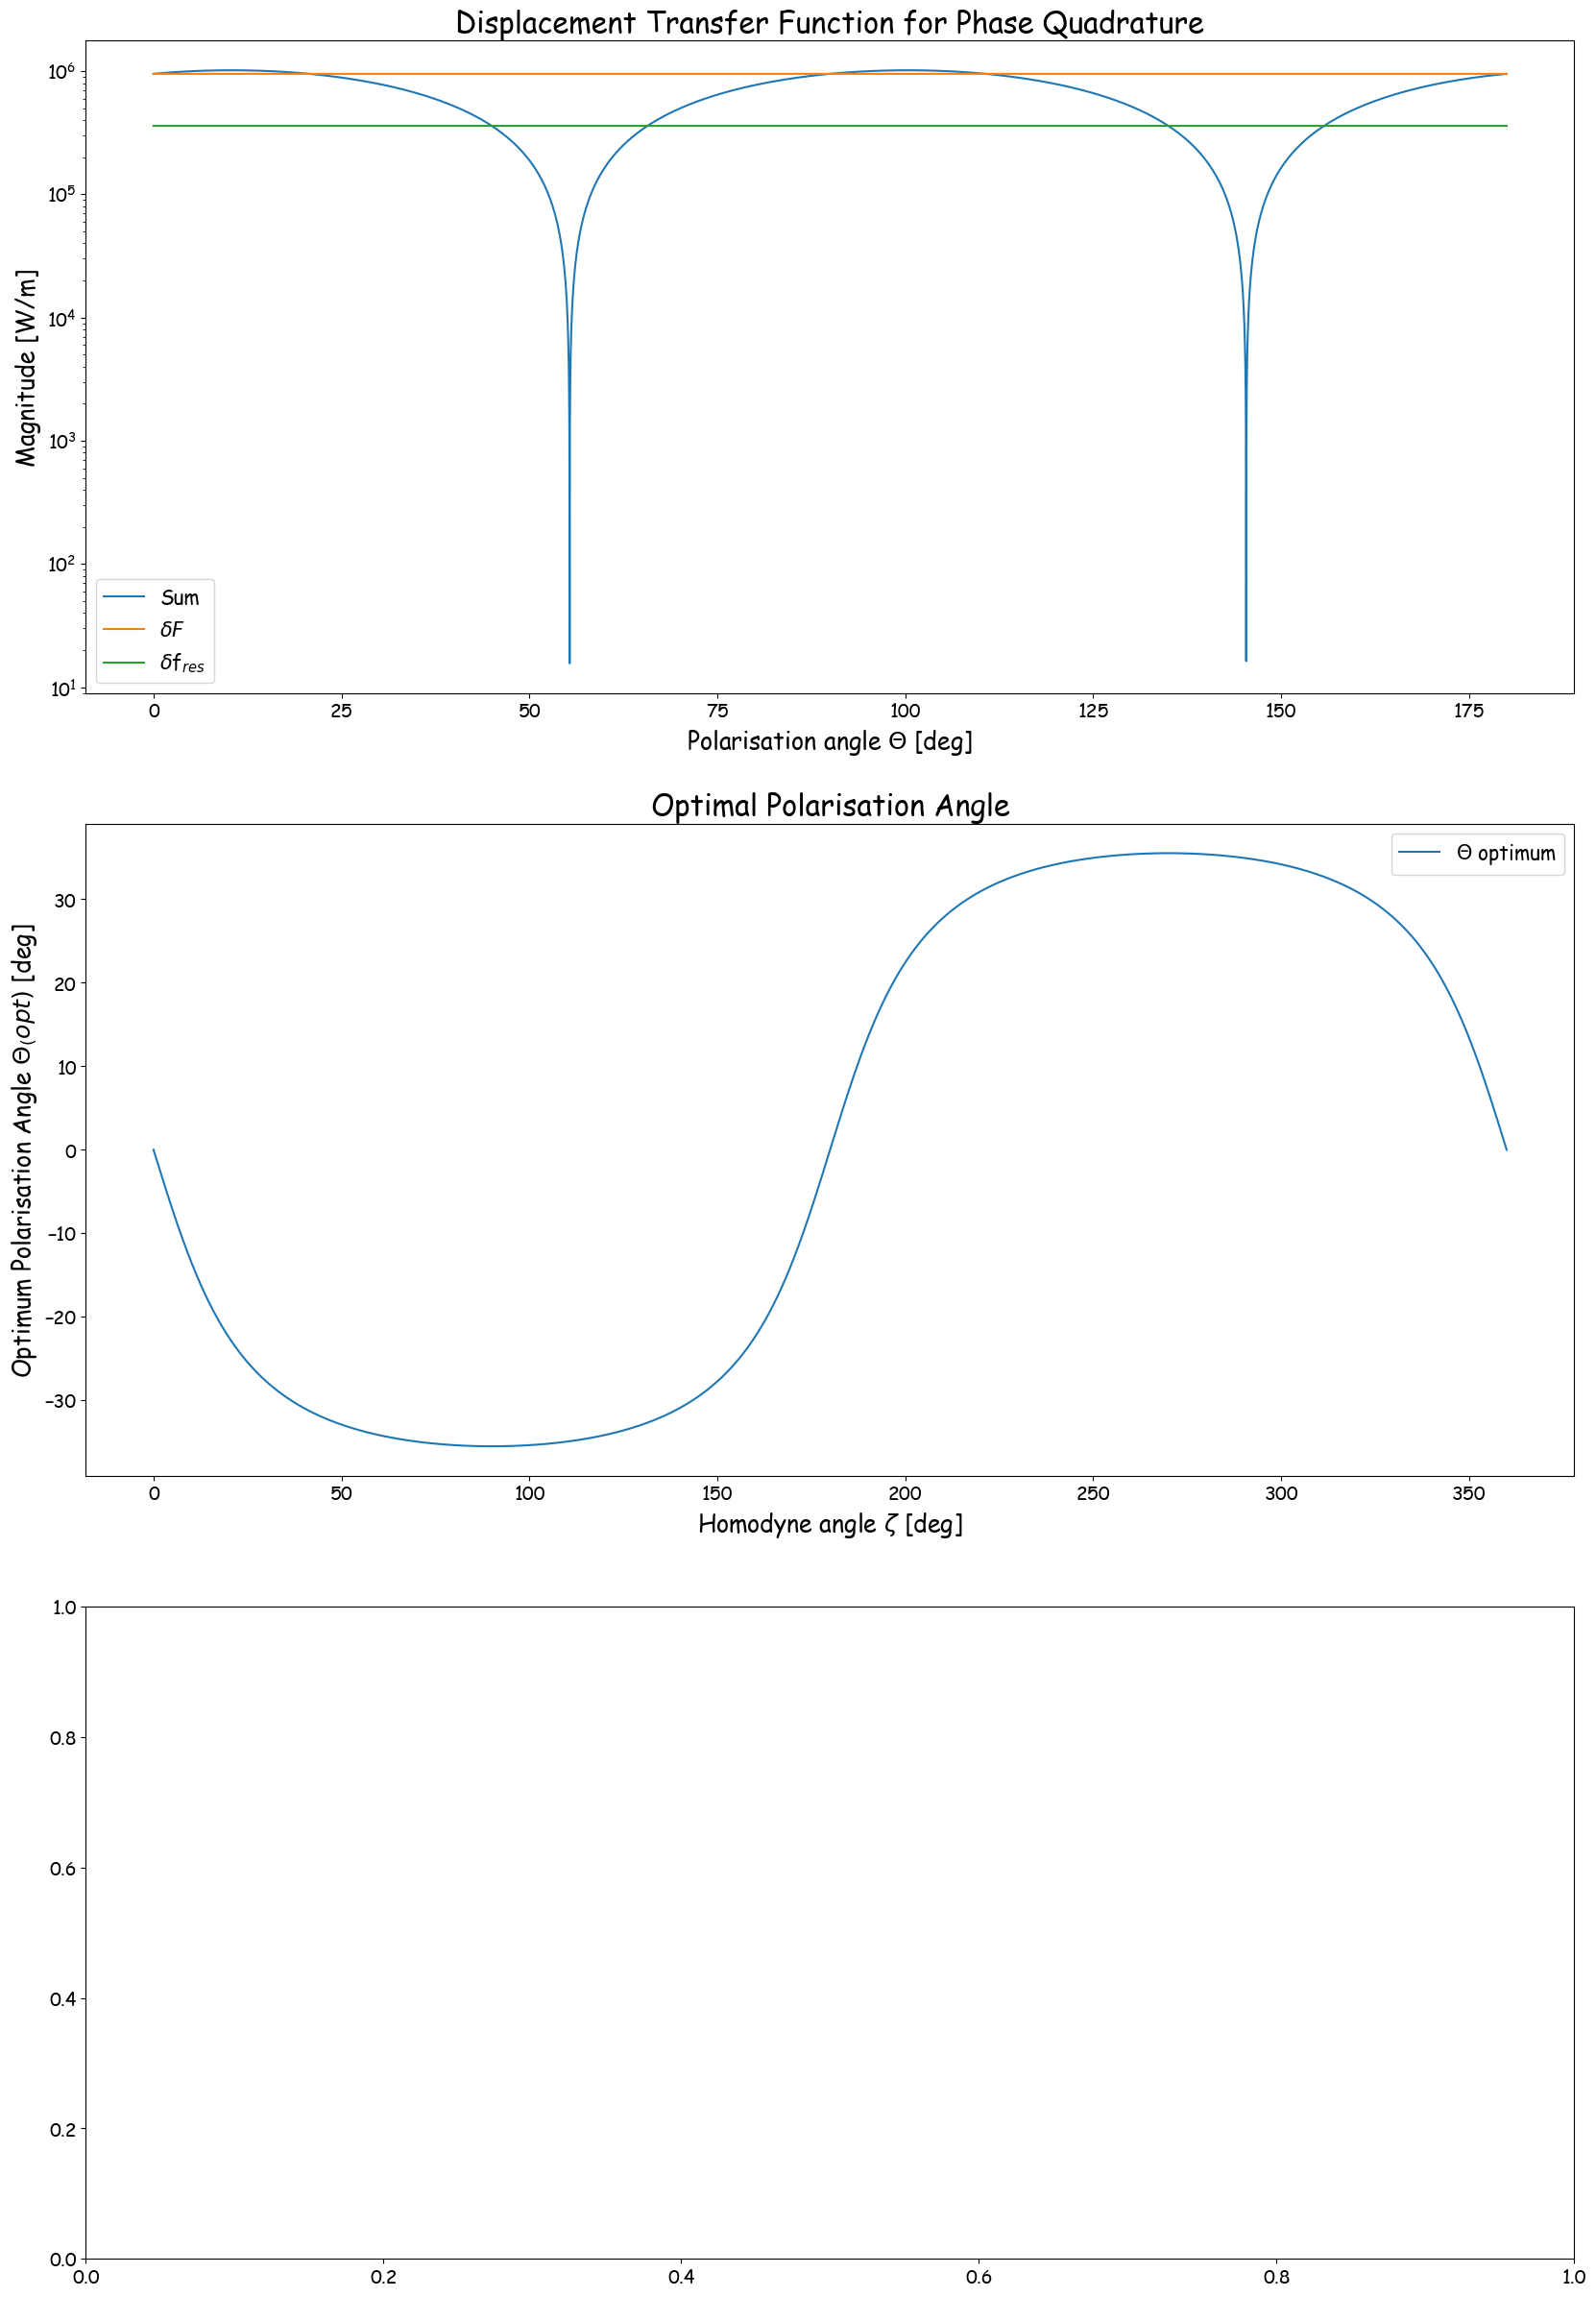

In [82]:
P_LO =10e-3
P_IFO = 1e-3
f_FSR = 268*10**6
f_c = 340e3
beta = 80/(f_FSR/(2*f_c))
delta_v0 = 30e3/(f_c)
zeta = np.pi/2
wavelength = 1064e-9
theta  = np.linspace(0,np.pi, 100000)
SpSx_optimised = []
SpSx_fin = []
SpSx_freso = []

for angle in theta:
    SpSx_optimised.append(SpSx_opt(P_LO, P_IFO, f_FSR, beta,delta_v0, f_c, zeta, angle))
    SpSx_fin.append(SpSx_finesse(P_LO, P_IFO, f_FSR, beta, f_c, zeta))
    SpSx_freso.append(SpSx_fres(P_LO, P_IFO, f_FSR ,delta_v0, f_c))
   
fig,ax  = plt.subplots(3,1,figsize = (20,30))
ax[0].plot(theta*180/np.pi,SpSx_optimised, label="Sum")
ax[0].plot(theta*180/np.pi,SpSx_fin, label = "$\delta F$")
ax[0].plot(theta*180/np.pi,SpSx_freso, label="$\delta$f$_{res}$")
ax[0].set_yscale('log')
ax[0].legend()
ax[0].set_title("Displacement Transfer Function for Phase Quadrature")
ax[0].set_ylabel("Magnitude [W/m]")
ax[0].set_xlabel("Polarisation angle $\Theta $ [deg]")

# Create an array of zeta values to plot against
zeta_values = np.linspace(0, 2*np.pi, 10000)  # zeta varies from 0 to pi

# Calculate theta_opt for each zeta
theta_opt_values = [theta_opt(P_LO, P_IFO, beta, delta_v0, zeta, theta) for zeta in zeta_values]

ax[1].plot(zeta_values*180/np.pi, theta_opt_values, label="$\Theta$ optimum")

ax[1].legend()
ax[1].set_title("Optimal Polarisation Angle")
ax[1].set_ylabel("Optimum Polarisation Angle $\Theta_(opt)$ [deg]")
ax[1].set_xlabel("Homodyne angle $\zeta$ [deg]")
f = np.linspace(-10000e3, 10000e3, 10000)
# ax[2].plot(f, L(f,0,f_c, A=P_LO)-L(f,-delta_fres,f_c+(delta_finesse*f_c**2/f_FSR), A=P_IFO))
# ax[2].set_title("This is what the signal sould look like")
# example_signal =[] 
# for i in f:
#     example_signal.append(L(i,0,f_c, A=P_LO)-L(i,-delta_fres,f_c+(delta_finesse*f_c**2/f_FSR), A=P_IFO))
# example_signal = np.array(example_signal)

# print ("The inner product resonance freq difference is",bir_res(f,0,f_c,1, example_signal)/1e3, "kHz")
# print ("The inner product finesse diference is",bir_finesse(f,0,f_c,1, example_signal, f_FSR)[1])
# check_orthogonality([f,0,f_c,1])


# Plot from data

In [10]:
pda20cs_v_a = 1.51e3 #V/A
pda20cs_a_w = 0.5 # A/W

P_LO = 2/(pda20cs_v_a*pda20cs_a_w)
P_IFO = 0.2/(pda20cs_v_a*pda20cs_a_w)
print (P_LO, P_IFO)

zeta = np.pi/2
theta  = np.linspace(300*np.pi/180,2*np.pi, 1000)

delta_v0 = np.abs(del_v0)

print (delta_v0)
beta = popt3[2]
print (beta)

0.0026490066225165563 0.00026490066225165563
0.01861921909151821
0.009232068410930602


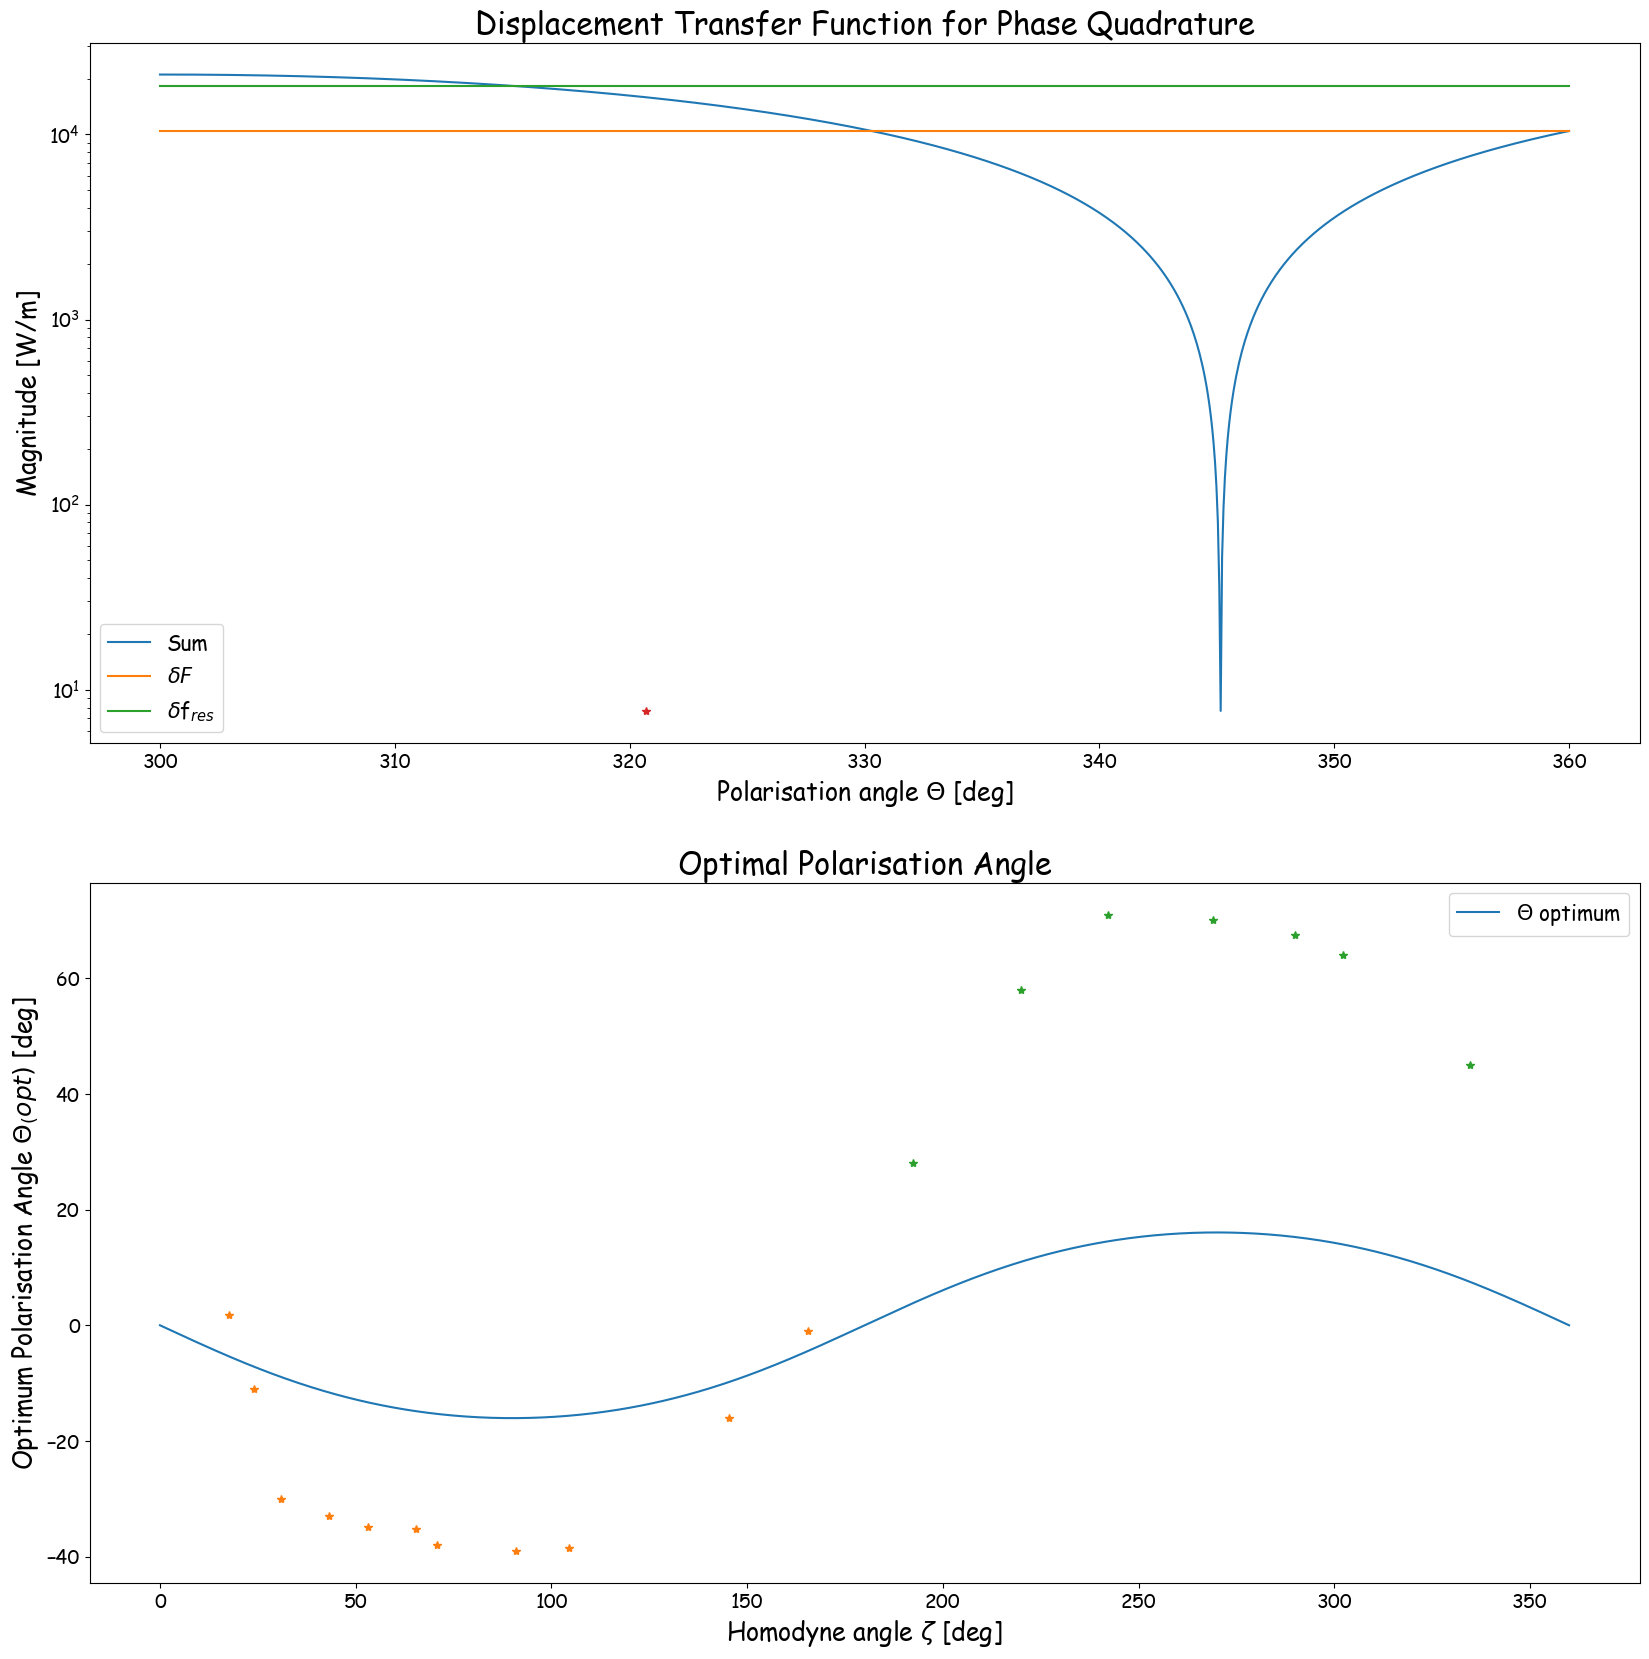

In [15]:
SpSx_optimised = []
SpSx_fin = []
SpSx_freso = []

for angle in theta:
    SpSx_optimised.append(SpSx_opt(P_LO, P_IFO, FSR, beta,delta_v0, gamma, zeta, angle))
    SpSx_fin.append(SpSx_finesse(P_LO, P_IFO, FSR, beta, gamma, zeta))
    SpSx_freso.append(SpSx_fres(P_LO, P_IFO, FSR ,delta_v0, gamma))

fig,ax  = plt.subplots(2,1,figsize = (20,20))
ax[0].plot(theta*180/np.pi,SpSx_optimised, label="Sum")
ax[0].plot(theta*180/np.pi,SpSx_fin, label = "$\delta F$")
ax[0].plot(theta*180/np.pi,SpSx_freso, label="$\delta$f$_{res}$")
ax[0].set_yscale('log')
ax[0].legend()
ax[0].set_title("Displacement Transfer Function for Phase Quadrature")
ax[0].set_ylabel("Magnitude [W/m]")
ax[0].set_xlabel("Polarisation angle $\Theta $ [deg]")

# Create an array of zeta values to plot against
zeta_values = np.linspace(0, 2*np.pi, 1000)  # zeta varies from 0 to pi

# Calculate theta_opt for each zeta
theta_opt_values = [theta_opt(P_LO, P_IFO, beta, delta_v0, zeta, theta) for zeta in zeta_values]

ax[1].plot(zeta_values*180/np.pi, theta_opt_values, label="$\Theta$ optimum")

# data from cell 183
ref = np.array([0,1.9,2.38,3.38, 4.1, 4.8, 5.1, 5.32,
                -1.26, -5.2, -4.4])

ref2 = np.array([-2.1*5/2, -4.10,-2.45,0,1.97,3.03,5.05])
max_ref = 2.23*5/2
min_ref = -2.15*5/2

ofs_ref = (max_ref + min_ref)/2
amp_ref = (max_ref - min_ref)/2
#max_ref = np.sqrt(1.8*0.18)*2*5
eta = np.arccos((ref-ofs_ref)/amp_ref)
eta2 = np.arccos(-(ref2-ofs_ref)/amp_ref)+np.pi
# print(eta*180/np.pi)
# print(eta2*180/np.pi)
opt = np.array([321,322,324.8,325.2,327,330,349,360+1.7,
       321.5,359,344])-360
opt2 = np.array([28, 58 ,71, 70, 67.5, 64, 45])


ax[1].plot(eta*180/np.pi,(opt),'*')
ax[1].plot(eta2*180/np.pi,(opt2),'*')

#ax.set_xlabel('homodyne angle [deg]')
ax[1].legend()
ax[1].set_title("Optimal Polarisation Angle")
ax[1].set_ylabel("Optimum Polarisation Angle $\Theta_(opt)$ [deg]")
ax[1].set_xlabel("Homodyne angle $\zeta$ [deg]")
ax[0].plot([320.7], np.min(SpSx_optimised),"*" )

In [94]:
finesse = FSR/(2*gamma)
print (beta*finesse)
fsr = (266.4621146+266.4620553)/2
print (10**3*delta_v0*fsr/(2*finesse))
print (popt3[2])

3.315496352364333
6.9074436059759785
0.009232068410930602


In [49]:
P_IFO/P_LO

0.1

In [76]:
pda20cs_v_a = 1.51e3 #V/A
pda20cs_a_w = 0.5 # A/W

P_LO = 2/(pda20cs_v_a*pda20cs_a_w)
P_IFO = 0.2/(pda20cs_v_a*pda20cs_a_w)
print (P_LO, P_IFO)
f_FSR = FSR*10**6
f_c = gamma_ro*10**6
delta_gamma = np.abs(gamma_fit3*10**6)
delta_finesse =FSR*delta_gamma/(gamma_ro*(gamma_ro+delta_gamma))

delta_fres = np.abs(f0_fit3*10**6)

zeta = np.pi/2
wavelength = 1064e-9
theta  = np.linspace(300*np.pi/180,2*np.pi, 100000)
SpSx_optimised = []
SpSx_fin = []
SpSx_freso = []
theta_opt_values = [theta_opt(P_LO, P_IFO, f_FSR, delta_finesse, delta_fres, f_c, zeta, wavelength, theta) for zeta in zeta_values]


0.0026490066225165563 0.00026490066225165563


TypeError: theta_opt() missing 2 required positional arguments: 'wavelength' and 'theta'